In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
import os
path = os.getcwd()
abspath = os.path.abspath(os.path.join(path, os.pardir))
path = abspath + '/imagesMasks'

In [3]:
num_skipped = 0
for folder_name in ("Faces", "Masks"):
    folder_path = os.path.join(path, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 0 images


In [10]:
!pip install deepface
from deepface import DeepFace
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
!pip install cmake
!pip install dlib

In [6]:
pathImageFolder = abspath + '/imagesV2'                             
folderList = os.listdir(pathImageFolder)

newImageFolder = abspath + '/imagesClassCrop'

if not os.path.exists(newImageFolder):
            os.mkdir(newImageFolder)

In [12]:
for folder in folderList:
   
    pathFolder = pathImageFolder + '/' + folder + '/crop'
    myFiles = [f for f in os.listdir(pathFolder) if f.endswith('.jpg')]
    
    print(folder)
    
    for file in range(len(myFiles)):
                
        file_name = myFiles[file]
        
        print(pathFolder + file_name)
        
        
        if not os.path.exists(newImageFolder +'/' + folder + '/'):
            os.mkdir(newImageFolder +'/' + folder + '/')
        
        try:
            face = DeepFace.detectFace(img_path = pathFolder + '/' + file_name, target_size = (224, 224), detector_backend = "dlib")
            plt.imsave(newImageFolder +'/' + folder + '/' + file_name, face)
        except ValueError:
            print(ValueError)
            print(file_name)
            #os.remove(pathFolder + '/' + file_name)

AngelaMerkel
/tf/src/imagesV2/AngelaMerkel/crop001_aff9cc74.jpg
/tf/src/imagesV2/AngelaMerkel/crop002_ea5c9f9b.jpg
/tf/src/imagesV2/AngelaMerkel/crop003_fd78327d.jpg
/tf/src/imagesV2/AngelaMerkel/crop004_8fb40073.jpg
/tf/src/imagesV2/AngelaMerkel/crop005_ef7992b3.jpg
/tf/src/imagesV2/AngelaMerkel/crop006_ba96e36b.jpg
/tf/src/imagesV2/AngelaMerkel/crop007_241f4273.jpg
/tf/src/imagesV2/AngelaMerkel/crop008_97cb3899.jpg
/tf/src/imagesV2/AngelaMerkel/crop009_94f54c4e.jpg
/tf/src/imagesV2/AngelaMerkel/crop010_0ae84573.jpg
/tf/src/imagesV2/AngelaMerkel/crop011_7bd48b2b.jpg
/tf/src/imagesV2/AngelaMerkel/crop012_cc66d81f.jpg
/tf/src/imagesV2/AngelaMerkel/crop013_6c066e1f.jpg
/tf/src/imagesV2/AngelaMerkel/crop014_a1611f6c.jpg
/tf/src/imagesV2/AngelaMerkel/crop015_4be4160b.jpg
/tf/src/imagesV2/AngelaMerkel/crop016_2bdd8de1.jpg
/tf/src/imagesV2/AngelaMerkel/crop017_63dac1ff.jpg
/tf/src/imagesV2/AngelaMerkel/crop018_e2b73dd1.jpg
/tf/src/imagesV2/AngelaMerkel/crop019_1f30c56b.jpg
/tf/src/imagesV2/A

/tf/src/imagesV2/AngelaMerkel/crop163_c0d243bf.jpg
/tf/src/imagesV2/AngelaMerkel/crop164_3a12b622.jpg
/tf/src/imagesV2/AngelaMerkel/crop165_c41845c4.jpg
/tf/src/imagesV2/AngelaMerkel/crop166_35dbf033.jpg
/tf/src/imagesV2/AngelaMerkel/crop167_5e10241b.jpg
<class 'ValueError'>
167_5e10241b.jpg
/tf/src/imagesV2/AngelaMerkel/crop168_664a5cf4.jpg
/tf/src/imagesV2/AngelaMerkel/crop169_ce576466.jpg
/tf/src/imagesV2/AngelaMerkel/crop170_f5461fa7.jpg
/tf/src/imagesV2/AngelaMerkel/crop171_bc280082.jpg
/tf/src/imagesV2/AngelaMerkel/crop172_64a953e5.jpg
/tf/src/imagesV2/AngelaMerkel/crop174_05e29986.jpg
/tf/src/imagesV2/AngelaMerkel/crop175_d568450e.jpg
/tf/src/imagesV2/AngelaMerkel/crop176_aa76fba4.jpg
/tf/src/imagesV2/AngelaMerkel/crop177_fe2ecf28.jpg
/tf/src/imagesV2/AngelaMerkel/crop178_f083b20d.jpg
/tf/src/imagesV2/AngelaMerkel/crop179_3e1ebdb7.jpg
/tf/src/imagesV2/AngelaMerkel/crop180_6abd7f79.jpg
/tf/src/imagesV2/AngelaMerkel/crop181_b82715cb.jpg
/tf/src/imagesV2/AngelaMerkel/crop182_c984da

/tf/src/imagesV2/AnnalenaBaerbock/crop029_3590260b.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop030_04e0f1fa.jpg
<class 'ValueError'>
030_04e0f1fa.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop031_d6366431.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop032_e3ad7a94.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop033_419a0d45.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop034_554d844c.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop035_c6c9ee3b.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop036_5c99cbc8.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop037_f211dafc.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop038_b2461855.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop039_0e698f39.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop040_a3dcd5d7.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop041_601538c2.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop042_ffef36e2.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop043_befb7ec3.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop044_0a6e1518.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop045_908b11b9.jpg
/tf/src/imagesV2/AnnalenaBa

/tf/src/imagesV2/AnnalenaBaerbock/crop183_51566e93.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop184_8413edc3.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop185_a1bb19a2.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop186_a57a3e28.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop187_6727eef5.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop188_555721a1.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop189_a19e9994.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop190_82f96383.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop191_f67f7940.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop192_8420e2d6.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop193_0e21d1ff.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop194_61f0c15f.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop195_7e732f32.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop196_0a3f3f36.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop197_cbd23f33.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop198_731fbd05.jpg
<class 'ValueError'>
198_731fbd05.jpg
/tf/src/imagesV2/AnnalenaBaerbock/crop199_fe4ed02f.jpg
/tf/src/imagesV2/AnnalenaBa

/tf/src/imagesV2/AnthonyFauci/crop039_7ebcba5a.jpg
/tf/src/imagesV2/AnthonyFauci/crop040_57eb7e30.jpg
/tf/src/imagesV2/AnthonyFauci/crop041_fc79bccf.jpg
/tf/src/imagesV2/AnthonyFauci/crop042_dc30cdfa.jpg
/tf/src/imagesV2/AnthonyFauci/crop043_4a201b9d.jpg
/tf/src/imagesV2/AnthonyFauci/crop044_21b92caf.jpg
/tf/src/imagesV2/AnthonyFauci/crop045_845e42cb.jpg
/tf/src/imagesV2/AnthonyFauci/crop046_7c6795cc.jpg
/tf/src/imagesV2/AnthonyFauci/crop047_90ecb00c.jpg
/tf/src/imagesV2/AnthonyFauci/crop048_ef918dbb.jpg
/tf/src/imagesV2/AnthonyFauci/crop050_741aa976.jpg
/tf/src/imagesV2/AnthonyFauci/crop051_4351a386.jpg
<class 'ValueError'>
051_4351a386.jpg
/tf/src/imagesV2/AnthonyFauci/crop052_68ee5762.jpg
/tf/src/imagesV2/AnthonyFauci/crop053_855db128.jpg
/tf/src/imagesV2/AnthonyFauci/crop054_8a6ae870.jpg
/tf/src/imagesV2/AnthonyFauci/crop055_f802f0cf.jpg
/tf/src/imagesV2/AnthonyFauci/crop056_e137bd95.jpg
/tf/src/imagesV2/AnthonyFauci/crop057_c2b513d7.jpg
/tf/src/imagesV2/AnthonyFauci/crop058_4b47d1

/tf/src/imagesV2/AnthonyFauci/crop205_01ef5b3c.jpg
/tf/src/imagesV2/AnthonyFauci/crop206_06b15140.jpg
/tf/src/imagesV2/AnthonyFauci/crop208_57307d52.jpg
/tf/src/imagesV2/AnthonyFauci/crop209_41ebbb87.jpg
/tf/src/imagesV2/AnthonyFauci/crop210_cff6c01c.jpg
/tf/src/imagesV2/AnthonyFauci/crop211_523e2d59.jpg
/tf/src/imagesV2/AnthonyFauci/crop212_87d38a8b.jpg
/tf/src/imagesV2/AnthonyFauci/crop213_8b8c5f56.jpg
/tf/src/imagesV2/AnthonyFauci/crop214_ee16d481.jpg
/tf/src/imagesV2/AnthonyFauci/crop215_84066a4e.jpg
/tf/src/imagesV2/AnthonyFauci/crop217_f9de668b.jpg
/tf/src/imagesV2/AnthonyFauci/crop218_cdf9da3f.jpg
/tf/src/imagesV2/AnthonyFauci/crop219_b10a7f17.jpg
/tf/src/imagesV2/AnthonyFauci/crop220_85c33e1d.jpg
/tf/src/imagesV2/AnthonyFauci/crop221_b1c0fbc9.jpg
/tf/src/imagesV2/AnthonyFauci/crop222_b31def53.jpg
/tf/src/imagesV2/AnthonyFauci/crop223_5b1c5565.jpg
/tf/src/imagesV2/AnthonyFauci/crop224_d3b22861.jpg
/tf/src/imagesV2/AnthonyFauci/crop225_92a21ae8.jpg
/tf/src/imagesV2/AnthonyFauci/c

/tf/src/imagesV2/ArnoldSchwarzenegger/crop065_1ddf694b.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop066_cc3f0a26.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop067_ade142c0.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop068_65b2ef0b.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop069_aa02ff2c.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop070_1f32044a.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop071_75116862.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop072_a2c1859f.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop073_8b763170.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop074_a879a7c9.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop075_553d51a5.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop076_23a2a473.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop077_b4fd1b22.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop078_c9109716.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop079_4befda7d.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop080_ce5a1fce.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop081_ac02e2c8.j

/tf/src/imagesV2/ArnoldSchwarzenegger/crop208_47fbe21d.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop209_8e3be91a.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop210_5d316424.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop211_c464be75.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop212_edbfcc2a.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop213_a7b3aa76.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop214_ebab1f98.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop215_f813311e.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop216_f95588c4.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop217_923f1d1a.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop219_876e21da.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop220_2d487303.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop221_e577b4f8.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop222_70eb7136.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop223_b899883c.jpg
<class 'ValueError'>
223_b899883c.jpg
/tf/src/imagesV2/ArnoldSchwarzenegger/crop224_a22a6702.jpg
/tf/src/imagesV2/A

/tf/src/imagesV2/BarackObama/crop072_731813a5.jpg
/tf/src/imagesV2/BarackObama/crop073_27a0b63c.jpg
/tf/src/imagesV2/BarackObama/crop074_f7605dfc.jpg
/tf/src/imagesV2/BarackObama/crop075_cd1fd126.jpg
/tf/src/imagesV2/BarackObama/crop076_ce7f2bca.jpg
/tf/src/imagesV2/BarackObama/crop077_0691f0df.jpg
/tf/src/imagesV2/BarackObama/crop078_1f82e15a.jpg
/tf/src/imagesV2/BarackObama/crop079_96087cd8.jpg
/tf/src/imagesV2/BarackObama/crop080_d3a80d07.jpg
/tf/src/imagesV2/BarackObama/crop081_582bc3a2.jpg
/tf/src/imagesV2/BarackObama/crop082_cfd15924.jpg
/tf/src/imagesV2/BarackObama/crop083_5f0a6d20.jpg
/tf/src/imagesV2/BarackObama/crop084_a5e96cdc.jpg
/tf/src/imagesV2/BarackObama/crop085_3413d15d.jpg
/tf/src/imagesV2/BarackObama/crop086_24d460a6.jpg
/tf/src/imagesV2/BarackObama/crop087_25a9c297.jpg
/tf/src/imagesV2/BarackObama/crop088_31592e9f.jpg
/tf/src/imagesV2/BarackObama/crop089_5a97e992.jpg
/tf/src/imagesV2/BarackObama/crop090_24bc8b0f.jpg
/tf/src/imagesV2/BarackObama/crop091_df81834f.jpg


/tf/src/imagesV2/BarackObama/crop250_39a4d17b.jpg
/tf/src/imagesV2/BarackObama/crop251_d1c69fc0.jpg
/tf/src/imagesV2/BarackObama/crop252_bb0401fe.jpg
/tf/src/imagesV2/BarackObama/crop253_2b737314.jpg
/tf/src/imagesV2/BarackObama/crop254_41073941.jpg
/tf/src/imagesV2/BarackObama/crop255_37054488.jpg
/tf/src/imagesV2/BarackObama/crop256_c9287d06.jpg
/tf/src/imagesV2/BarackObama/crop257_44a8796e.jpg
/tf/src/imagesV2/BarackObama/crop258_4a57ab68.jpg
/tf/src/imagesV2/BarackObama/crop259_40f3f1be.jpg
/tf/src/imagesV2/BarackObama/crop260_03a43fe3.jpg
/tf/src/imagesV2/BarackObama/crop261_877f32e3.jpg
/tf/src/imagesV2/BarackObama/crop262_622823b3.jpg
/tf/src/imagesV2/BarackObama/crop263_f7cd204f.jpg
/tf/src/imagesV2/BarackObama/crop264_9856c583.jpg
/tf/src/imagesV2/BarackObama/crop265_bb4561ef.jpg
/tf/src/imagesV2/BarackObama/crop266_8fe440dc.jpg
/tf/src/imagesV2/BarackObama/crop267_f3f15753.jpg
/tf/src/imagesV2/BarackObama/crop268_2a3dedcd.jpg
/tf/src/imagesV2/BarackObama/crop269_e9010e1a.jpg


/tf/src/imagesV2/BenedictCumberbatch/crop109_e9bc3326.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop110_e5888d88.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop111_984780b3.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop112_ee2f5f67.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop113_308cfe7a.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop114_fed81071.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop115_6acbbd63.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop116_d24fa44f.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop117_2dea0e9b.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop118_56b85161.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop119_35e7b126.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop120_240db143.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop121_6e0f84f6.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop122_a5ffc395.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop123_44183ad1.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop124_10c5ab39.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop125_b9fce077.jpg
/tf/src/images

/tf/src/imagesV2/BenedictCumberbatch/crop254_0f5aa077.jpg
<class 'ValueError'>
254_0f5aa077.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop255_7f055d0c.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop256_aef4e0d5.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop257_4317264c.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop259_d38ee688.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop260_8ce684be.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop261_5325523b.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop262_f32cffac.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop263_6e545e66.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop264_04040b63.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop265_c659b3d7.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop266_d055496d.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop267_e3e1af49.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop268_3b178f8b.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop269_93827a10.jpg
/tf/src/imagesV2/BenedictCumberbatch/crop271_a3248859.jpg
/tf/src/imagesV2/BenedictCumberbat

/tf/src/imagesV2/BradPitt/crop127_66fbf0ee.jpg
/tf/src/imagesV2/BradPitt/crop128_8906b6a5.jpg
/tf/src/imagesV2/BradPitt/crop129_7312fa26.jpg
<class 'ValueError'>
129_7312fa26.jpg
/tf/src/imagesV2/BradPitt/crop130_1f3b719e.jpg
/tf/src/imagesV2/BradPitt/crop131_969c1f6b.jpg
/tf/src/imagesV2/BradPitt/crop132_aa40624e.jpg
/tf/src/imagesV2/BradPitt/crop133_33bea904.jpg
/tf/src/imagesV2/BradPitt/crop134_e85e809c.jpg
/tf/src/imagesV2/BradPitt/crop135_811a6b00.jpg
/tf/src/imagesV2/BradPitt/crop136_f9843c6a.jpg
/tf/src/imagesV2/BradPitt/crop137_b8b10e91.jpg
/tf/src/imagesV2/BradPitt/crop138_11b9af24.jpg
/tf/src/imagesV2/BradPitt/crop139_25e4f27d.jpg
/tf/src/imagesV2/BradPitt/crop140_456d8eb5.jpg
/tf/src/imagesV2/BradPitt/crop141_5f5a64da.jpg
/tf/src/imagesV2/BradPitt/crop142_7de00669.jpg
/tf/src/imagesV2/BradPitt/crop143_3b84aabf.jpg
/tf/src/imagesV2/BradPitt/crop144_a486e8bb.jpg
/tf/src/imagesV2/BradPitt/crop145_7226acbd.jpg
/tf/src/imagesV2/BradPitt/crop146_e8e3a06a.jpg
/tf/src/imagesV2/BradP

/tf/src/imagesV2/ChadwickBoseman/crop002_d71ed242.jpg
/tf/src/imagesV2/ChadwickBoseman/crop003_9f92d1d0.jpg
/tf/src/imagesV2/ChadwickBoseman/crop004_e95e239c.jpg
/tf/src/imagesV2/ChadwickBoseman/crop005_52d5fbc3.jpg
/tf/src/imagesV2/ChadwickBoseman/crop006_3b9d57c8.jpg
/tf/src/imagesV2/ChadwickBoseman/crop007_f3d7dd93.jpg
/tf/src/imagesV2/ChadwickBoseman/crop008_5dbc3bc4.jpg
/tf/src/imagesV2/ChadwickBoseman/crop009_f847dc39.jpg
/tf/src/imagesV2/ChadwickBoseman/crop010_4e22ddeb.jpg
/tf/src/imagesV2/ChadwickBoseman/crop011_520548f5.jpg
/tf/src/imagesV2/ChadwickBoseman/crop012_555ce787.jpg
/tf/src/imagesV2/ChadwickBoseman/crop013_696c01cb.jpg
/tf/src/imagesV2/ChadwickBoseman/crop014_468e8377.jpg
/tf/src/imagesV2/ChadwickBoseman/crop015_99dbd4af.jpg
/tf/src/imagesV2/ChadwickBoseman/crop016_c361c5d5.jpg
/tf/src/imagesV2/ChadwickBoseman/crop017_891a2a9f.jpg
/tf/src/imagesV2/ChadwickBoseman/crop018_7d3e02a5.jpg
/tf/src/imagesV2/ChadwickBoseman/crop019_7b16977f.jpg
/tf/src/imagesV2/ChadwickBos

/tf/src/imagesV2/ChadwickBoseman/crop162_5e9a6849.jpg
/tf/src/imagesV2/ChadwickBoseman/crop163_263650d4.jpg
/tf/src/imagesV2/ChadwickBoseman/crop164_aac522ca.jpg
/tf/src/imagesV2/ChadwickBoseman/crop165_4751c8f1.jpg
/tf/src/imagesV2/ChadwickBoseman/crop166_2fd1e909.jpg
/tf/src/imagesV2/ChadwickBoseman/crop167_86fb87f2.jpg
/tf/src/imagesV2/ChadwickBoseman/crop168_ca7db4e3.jpg
/tf/src/imagesV2/ChadwickBoseman/crop169_7910f905.jpg
/tf/src/imagesV2/ChadwickBoseman/crop170_21e98c1f.jpg
/tf/src/imagesV2/ChadwickBoseman/crop172_d80d69cc.jpg
/tf/src/imagesV2/ChadwickBoseman/crop173_68026644.jpg
/tf/src/imagesV2/ChadwickBoseman/crop174_d4eec47b.jpg
/tf/src/imagesV2/ChadwickBoseman/crop175_ff44b11c.jpg
/tf/src/imagesV2/ChadwickBoseman/crop176_9e7dfc0c.jpg
/tf/src/imagesV2/ChadwickBoseman/crop177_d710d1d7.jpg
/tf/src/imagesV2/ChadwickBoseman/crop178_46583b27.jpg
/tf/src/imagesV2/ChadwickBoseman/crop180_0a41cc3f.jpg
/tf/src/imagesV2/ChadwickBoseman/crop181_0d3f076b.jpg
<class 'ValueError'>
181_0d3

/tf/src/imagesV2/ChrisHemsworth/crop022_d2e99311.jpg
<class 'ValueError'>
022_d2e99311.jpg
/tf/src/imagesV2/ChrisHemsworth/crop023_a0d587ff.jpg
/tf/src/imagesV2/ChrisHemsworth/crop024_e27f3c36.jpg
/tf/src/imagesV2/ChrisHemsworth/crop025_979a7e06.jpg
/tf/src/imagesV2/ChrisHemsworth/crop027_a313e1d6.jpg
/tf/src/imagesV2/ChrisHemsworth/crop028_830ec1ac.jpg
/tf/src/imagesV2/ChrisHemsworth/crop029_ff2427b8.jpg
/tf/src/imagesV2/ChrisHemsworth/crop030_1221abeb.jpg
/tf/src/imagesV2/ChrisHemsworth/crop031_98cd6754.jpg
/tf/src/imagesV2/ChrisHemsworth/crop032_098f72b0.jpg
/tf/src/imagesV2/ChrisHemsworth/crop033_ef2d11d6.jpg
/tf/src/imagesV2/ChrisHemsworth/crop034_868c3ec2.jpg
/tf/src/imagesV2/ChrisHemsworth/crop035_112705f3.jpg
/tf/src/imagesV2/ChrisHemsworth/crop036_4a21ff9c.jpg
/tf/src/imagesV2/ChrisHemsworth/crop038_89ef5099.jpg
/tf/src/imagesV2/ChrisHemsworth/crop039_39fbf530.jpg
/tf/src/imagesV2/ChrisHemsworth/crop040_50438883.jpg
/tf/src/imagesV2/ChrisHemsworth/crop041_abc60945.jpg
/tf/src/

/tf/src/imagesV2/ChrisHemsworth/crop198_252d1dec.jpg
/tf/src/imagesV2/ChrisHemsworth/crop199_f13801cc.jpg
/tf/src/imagesV2/ChrisHemsworth/crop200_2907f961.jpg
/tf/src/imagesV2/ChrisHemsworth/crop201_c38e86b3.jpg
/tf/src/imagesV2/ChrisHemsworth/crop202_81e2eaaa.jpg
/tf/src/imagesV2/ChrisHemsworth/crop203_0553ff53.jpg
/tf/src/imagesV2/ChrisHemsworth/crop204_5676623c.jpg
/tf/src/imagesV2/ChrisHemsworth/crop205_91bd3e8a.jpg
/tf/src/imagesV2/ChrisHemsworth/crop206_2cbcb904.jpg
/tf/src/imagesV2/ChrisHemsworth/crop207_53708877.jpg
/tf/src/imagesV2/ChrisHemsworth/crop208_696acd2f.jpg
/tf/src/imagesV2/ChrisHemsworth/crop210_f88b8762.jpg
/tf/src/imagesV2/ChrisHemsworth/crop211_baa93073.jpg
/tf/src/imagesV2/ChrisHemsworth/crop212_fe12fa1f.jpg
/tf/src/imagesV2/ChrisHemsworth/crop213_bef6b8cb.jpg
/tf/src/imagesV2/ChrisHemsworth/crop214_dfea80a5.jpg
/tf/src/imagesV2/ChrisHemsworth/crop215_b49b97ec.jpg
/tf/src/imagesV2/ChrisHemsworth/crop217_bd3153b8.jpg
/tf/src/imagesV2/ChrisHemsworth/crop218_add960

/tf/src/imagesV2/ChrisPratt/crop064_552d6f47.jpg
/tf/src/imagesV2/ChrisPratt/crop065_8604df30.jpg
/tf/src/imagesV2/ChrisPratt/crop066_ca485688.jpg
/tf/src/imagesV2/ChrisPratt/crop067_9a64900c.jpg
/tf/src/imagesV2/ChrisPratt/crop068_c7bdb184.jpg
/tf/src/imagesV2/ChrisPratt/crop069_cf3d11a1.jpg
/tf/src/imagesV2/ChrisPratt/crop070_a3979201.jpg
/tf/src/imagesV2/ChrisPratt/crop071_97389bad.jpg
/tf/src/imagesV2/ChrisPratt/crop072_ed578afc.jpg
/tf/src/imagesV2/ChrisPratt/crop073_bb0a1b28.jpg
/tf/src/imagesV2/ChrisPratt/crop074_c98a92b1.jpg
/tf/src/imagesV2/ChrisPratt/crop075_5db1c193.jpg
/tf/src/imagesV2/ChrisPratt/crop076_34058ca8.jpg
/tf/src/imagesV2/ChrisPratt/crop077_41ffe5a4.jpg
/tf/src/imagesV2/ChrisPratt/crop078_ec7ce7b5.jpg
/tf/src/imagesV2/ChrisPratt/crop079_08b15b94.jpg
/tf/src/imagesV2/ChrisPratt/crop080_48a00cb8.jpg
/tf/src/imagesV2/ChrisPratt/crop081_0558bda2.jpg
/tf/src/imagesV2/ChrisPratt/crop082_94fd6d71.jpg
/tf/src/imagesV2/ChrisPratt/crop083_1253b01a.jpg
/tf/src/imagesV2/Chr

/tf/src/imagesV2/ChrisPratt/crop241_bc41ace3.jpg
/tf/src/imagesV2/ChrisPratt/crop242_c07e63e0.jpg
/tf/src/imagesV2/ChrisPratt/crop243_cd744fa4.jpg
<class 'ValueError'>
243_cd744fa4.jpg
/tf/src/imagesV2/ChrisPratt/crop244_1bdbe47a.jpg
/tf/src/imagesV2/ChrisPratt/crop246_d73a0fb2.jpg
/tf/src/imagesV2/ChrisPratt/crop247_ad5aebf1.jpg
/tf/src/imagesV2/ChrisPratt/crop248_94cbe490.jpg
/tf/src/imagesV2/ChrisPratt/crop249_b6987b48.jpg
/tf/src/imagesV2/ChrisPratt/crop250_7c9854a8.jpg
/tf/src/imagesV2/ChrisPratt/crop251_1084a027.jpg
/tf/src/imagesV2/ChrisPratt/crop252_1796a004.jpg
/tf/src/imagesV2/ChrisPratt/crop253_8f0b201e.jpg
/tf/src/imagesV2/ChrisPratt/crop254_3cd2f877.jpg
/tf/src/imagesV2/ChrisPratt/crop255_be841361.jpg
/tf/src/imagesV2/ChrisPratt/crop256_f21cff48.jpg
/tf/src/imagesV2/ChrisPratt/crop257_c8b90472.jpg
/tf/src/imagesV2/ChrisPratt/crop258_73e87b39.jpg
/tf/src/imagesV2/ChrisPratt/crop259_926a1437.jpg
/tf/src/imagesV2/ChrisPratt/crop260_a319b47a.jpg
/tf/src/imagesV2/ChrisPratt/cro

/tf/src/imagesV2/ChristianBale/crop103_702d697d.jpg
/tf/src/imagesV2/ChristianBale/crop105_8ebb1e7f.jpg
/tf/src/imagesV2/ChristianBale/crop106_4dd2fe45.jpg
/tf/src/imagesV2/ChristianBale/crop107_0648c9f9.jpg
/tf/src/imagesV2/ChristianBale/crop108_fd59e995.jpg
/tf/src/imagesV2/ChristianBale/crop109_67947238.jpg
/tf/src/imagesV2/ChristianBale/crop110_b83c5866.jpg
/tf/src/imagesV2/ChristianBale/crop111_8c35419e.jpg
/tf/src/imagesV2/ChristianBale/crop112_7c2d535b.jpg
/tf/src/imagesV2/ChristianBale/crop113_7d1ebaea.jpg
/tf/src/imagesV2/ChristianBale/crop114_37f115f2.jpg
/tf/src/imagesV2/ChristianBale/crop115_b4fc2fc0.jpg
/tf/src/imagesV2/ChristianBale/crop116_19d1d918.jpg
/tf/src/imagesV2/ChristianBale/crop117_23bffb5a.jpg
/tf/src/imagesV2/ChristianBale/crop118_3d296740.jpg
/tf/src/imagesV2/ChristianBale/crop119_5f0e839c.jpg
/tf/src/imagesV2/ChristianBale/crop120_81a51773.jpg
/tf/src/imagesV2/ChristianBale/crop121_a7e8196e.jpg
<class 'ValueError'>
121_a7e8196e.jpg
/tf/src/imagesV2/Christian

/tf/src/imagesV2/ChristianBale/crop262_e45328cc.jpg
/tf/src/imagesV2/ChristianBale/crop263_484fa9f5.jpg
/tf/src/imagesV2/ChristianBale/crop264_eddeafc2.jpg
<class 'ValueError'>
264_eddeafc2.jpg
/tf/src/imagesV2/ChristianBale/crop265_12fa8d2a.jpg
/tf/src/imagesV2/ChristianBale/crop266_e82a6feb.jpg
/tf/src/imagesV2/ChristianBale/crop267_5406dcb4.jpg
/tf/src/imagesV2/ChristianBale/crop268_4ee1f081.jpg
/tf/src/imagesV2/ChristianBale/crop269_33cfb196.jpg
/tf/src/imagesV2/ChristianBale/crop270_210495d6.jpg
/tf/src/imagesV2/ChristianBale/crop271_faf69093.jpg
/tf/src/imagesV2/ChristianBale/crop272_b76d3652.jpg
/tf/src/imagesV2/ChristianBale/crop273_c9dd1c42.jpg
/tf/src/imagesV2/ChristianBale/crop274_1837a555.jpg
<class 'ValueError'>
274_1837a555.jpg
/tf/src/imagesV2/ChristianBale/crop275_2a6e9d00.jpg
/tf/src/imagesV2/ChristianBale/crop276_143850c1.jpg
/tf/src/imagesV2/ChristianBale/crop277_d15e4125.jpg
/tf/src/imagesV2/ChristianBale/crop278_0a1ae26c.jpg
/tf/src/imagesV2/ChristianBale/crop280_e

/tf/src/imagesV2/ChristianLindner/crop119_8d6bbea2.jpg
/tf/src/imagesV2/ChristianLindner/crop120_51fed8f7.jpg
/tf/src/imagesV2/ChristianLindner/crop121_c4ee9f12.jpg
/tf/src/imagesV2/ChristianLindner/crop122_b4f31811.jpg
/tf/src/imagesV2/ChristianLindner/crop123_35901e01.jpg
/tf/src/imagesV2/ChristianLindner/crop124_9faedb5a.jpg
/tf/src/imagesV2/ChristianLindner/crop125_487fa3d5.jpg
/tf/src/imagesV2/ChristianLindner/crop126_ff28f625.jpg
/tf/src/imagesV2/ChristianLindner/crop127_c24836fa.jpg
/tf/src/imagesV2/ChristianLindner/crop128_56c6742a.jpg
/tf/src/imagesV2/ChristianLindner/crop129_111a764e.jpg
<class 'ValueError'>
129_111a764e.jpg
/tf/src/imagesV2/ChristianLindner/crop131_dec29f5a.jpg
/tf/src/imagesV2/ChristianLindner/crop132_86f563b7.jpg
/tf/src/imagesV2/ChristianLindner/crop133_ba4d1fe6.jpg
/tf/src/imagesV2/ChristianLindner/crop134_3c2e0d94.jpg
<class 'ValueError'>
134_3c2e0d94.jpg
/tf/src/imagesV2/ChristianLindner/crop135_6667bbc7.jpg
/tf/src/imagesV2/ChristianLindner/crop136_09

/tf/src/imagesV2/ChristianLindner/crop264_d582edef.jpg
/tf/src/imagesV2/ChristianLindner/crop265_3d3f4ec7.jpg
/tf/src/imagesV2/ChristianLindner/crop266_ece9420c.jpg
/tf/src/imagesV2/ChristianLindner/crop267_7c103b69.jpg
/tf/src/imagesV2/ChristianLindner/crop268_7e0a31c9.jpg
/tf/src/imagesV2/ChristianLindner/crop269_2be539f9.jpg
/tf/src/imagesV2/ChristianLindner/crop270_ca18548e.jpg
/tf/src/imagesV2/ChristianLindner/crop271_68c0c289.jpg
/tf/src/imagesV2/ChristianLindner/crop272_2c7a0338.jpg
/tf/src/imagesV2/ChristianLindner/crop273_ba83689f.jpg
/tf/src/imagesV2/ChristianLindner/crop274_0722cd2e.jpg
/tf/src/imagesV2/ChristianLindner/crop275_9dd5c925.jpg
/tf/src/imagesV2/ChristianLindner/crop276_cc4762ca.jpg
/tf/src/imagesV2/ChristianLindner/crop277_b0af54ea.jpg
/tf/src/imagesV2/ChristianLindner/crop278_8d000fa1.jpg
/tf/src/imagesV2/ChristianLindner/crop279_2e42a1a8.jpg
/tf/src/imagesV2/ChristianLindner/crop280_6797ba19.jpg
/tf/src/imagesV2/ChristianLindner/crop281_55bd61ff.jpg
<class 'Va

/tf/src/imagesV2/CristianoRonaldo/crop113_c302f4cd.jpg
/tf/src/imagesV2/CristianoRonaldo/crop114_41e87171.jpg
/tf/src/imagesV2/CristianoRonaldo/crop115_485d691b.jpg
/tf/src/imagesV2/CristianoRonaldo/crop116_ba67f876.jpg
/tf/src/imagesV2/CristianoRonaldo/crop117_d8dcb99d.jpg
/tf/src/imagesV2/CristianoRonaldo/crop118_f81b07c6.jpg
/tf/src/imagesV2/CristianoRonaldo/crop119_8d1e6cb2.jpg
/tf/src/imagesV2/CristianoRonaldo/crop120_1feeb484.jpg
/tf/src/imagesV2/CristianoRonaldo/crop121_f3d4880e.jpg
<class 'ValueError'>
121_f3d4880e.jpg
/tf/src/imagesV2/CristianoRonaldo/crop122_9e5cfed3.jpg
/tf/src/imagesV2/CristianoRonaldo/crop123_1631fff8.jpg
/tf/src/imagesV2/CristianoRonaldo/crop124_fef7e3be.jpg
/tf/src/imagesV2/CristianoRonaldo/crop126_e9ce0c04.jpg
/tf/src/imagesV2/CristianoRonaldo/crop127_4cf854a2.jpg
/tf/src/imagesV2/CristianoRonaldo/crop128_6376adda.jpg
/tf/src/imagesV2/CristianoRonaldo/crop129_c271e949.jpg
/tf/src/imagesV2/CristianoRonaldo/crop130_2045abcf.jpg
/tf/src/imagesV2/CristianoR

/tf/src/imagesV2/CristianoRonaldo/crop275_e7895c54.jpg
<class 'ValueError'>
275_e7895c54.jpg
/tf/src/imagesV2/CristianoRonaldo/crop276_7a2a4361.jpg
/tf/src/imagesV2/CristianoRonaldo/crop277_61a1278b.jpg
/tf/src/imagesV2/CristianoRonaldo/crop278_878d0282.jpg
/tf/src/imagesV2/CristianoRonaldo/crop279_1cf9c905.jpg
/tf/src/imagesV2/CristianoRonaldo/crop280_44def60e.jpg
/tf/src/imagesV2/CristianoRonaldo/crop282_a23362b8.jpg
/tf/src/imagesV2/CristianoRonaldo/crop283_7e35554d.jpg
/tf/src/imagesV2/CristianoRonaldo/crop284_4c3e3a3b.jpg
/tf/src/imagesV2/CristianoRonaldo/crop285_62d5d5fd.jpg
/tf/src/imagesV2/CristianoRonaldo/crop286_7d2d5d8a.jpg
<class 'ValueError'>
286_7d2d5d8a.jpg
/tf/src/imagesV2/CristianoRonaldo/crop287_a8fe53e0.jpg
/tf/src/imagesV2/CristianoRonaldo/crop288_773faa08.jpg
/tf/src/imagesV2/CristianoRonaldo/crop289_1207a0f1.jpg
/tf/src/imagesV2/CristianoRonaldo/crop290_6d8204a4.jpg
/tf/src/imagesV2/CristianoRonaldo/crop291_65b27c31.jpg
/tf/src/imagesV2/CristianoRonaldo/crop292_6c

/tf/src/imagesV2/DenzelWashington/crop121_65e4e59a.jpg
/tf/src/imagesV2/DenzelWashington/crop122_f4a68031.jpg
/tf/src/imagesV2/DenzelWashington/crop123_2cc73bd6.jpg
/tf/src/imagesV2/DenzelWashington/crop124_6d9c4b01.jpg
/tf/src/imagesV2/DenzelWashington/crop125_8f2439b1.jpg
/tf/src/imagesV2/DenzelWashington/crop126_5b1d3ad4.jpg
/tf/src/imagesV2/DenzelWashington/crop127_934fafc6.jpg
/tf/src/imagesV2/DenzelWashington/crop128_c78c4ea6.jpg
/tf/src/imagesV2/DenzelWashington/crop129_a2991989.jpg
/tf/src/imagesV2/DenzelWashington/crop130_e0be2355.jpg
/tf/src/imagesV2/DenzelWashington/crop131_f0446d6a.jpg
/tf/src/imagesV2/DenzelWashington/crop132_9c980190.jpg
/tf/src/imagesV2/DenzelWashington/crop133_47b039b8.jpg
/tf/src/imagesV2/DenzelWashington/crop134_8be32c54.jpg
/tf/src/imagesV2/DenzelWashington/crop135_759073b0.jpg
/tf/src/imagesV2/DenzelWashington/crop136_ea0cdc26.jpg
/tf/src/imagesV2/DenzelWashington/crop137_e9284bf2.jpg
/tf/src/imagesV2/DenzelWashington/crop138_90e55c48.jpg
/tf/src/im

/tf/src/imagesV2/DenzelWashington/crop279_82581f77.jpg
/tf/src/imagesV2/DenzelWashington/crop280_6e6655b1.jpg
/tf/src/imagesV2/DenzelWashington/crop282_450f51c2.jpg
/tf/src/imagesV2/DenzelWashington/crop283_9a94aec2.jpg
/tf/src/imagesV2/DenzelWashington/crop284_4ff1e555.jpg
/tf/src/imagesV2/DenzelWashington/crop285_3643efa9.jpg
/tf/src/imagesV2/DenzelWashington/crop286_d37ccc6c.jpg
/tf/src/imagesV2/DenzelWashington/crop287_2f06582b.jpg
/tf/src/imagesV2/DenzelWashington/crop288_6f58f125.jpg
/tf/src/imagesV2/DenzelWashington/crop289_d15d0175.jpg
/tf/src/imagesV2/DenzelWashington/crop290_55d5cfcc.jpg
/tf/src/imagesV2/DenzelWashington/crop291_a4dcbe97.jpg
/tf/src/imagesV2/DenzelWashington/crop292_a04d8b63.jpg
/tf/src/imagesV2/DenzelWashington/crop293_7f75ea30.jpg
/tf/src/imagesV2/DenzelWashington/crop294_2ce19995.jpg
/tf/src/imagesV2/DenzelWashington/crop295_30e9fd45.jpg
/tf/src/imagesV2/DenzelWashington/crop296_8c9c2775.jpg
/tf/src/imagesV2/DenzelWashington/crop297_94dfa027.jpg
/tf/src/im

/tf/src/imagesV2/DonaldTrump/crop147_e2a8fc14.jpg
/tf/src/imagesV2/DonaldTrump/crop148_bc991d9b.jpg
/tf/src/imagesV2/DonaldTrump/crop149_e2a73fe2.jpg
/tf/src/imagesV2/DonaldTrump/crop150_4ecc44b1.jpg
/tf/src/imagesV2/DonaldTrump/crop151_a20b4c27.jpg
/tf/src/imagesV2/DonaldTrump/crop152_7e7f0139.jpg
/tf/src/imagesV2/DonaldTrump/crop154_0cc0b2cc.jpg
/tf/src/imagesV2/DonaldTrump/crop155_5686894f.jpg
/tf/src/imagesV2/DonaldTrump/crop156_bfe51cbb.jpg
/tf/src/imagesV2/DonaldTrump/crop157_c252133c.jpg
/tf/src/imagesV2/DonaldTrump/crop158_51295f83.jpg
/tf/src/imagesV2/DonaldTrump/crop159_f331d7d9.jpg
/tf/src/imagesV2/DonaldTrump/crop160_7b61aa3a.jpg
/tf/src/imagesV2/DonaldTrump/crop161_889c03ad.jpg
/tf/src/imagesV2/DonaldTrump/crop162_bab78cab.jpg
/tf/src/imagesV2/DonaldTrump/crop163_32e3c21d.jpg
/tf/src/imagesV2/DonaldTrump/crop164_87ea74fa.jpg
/tf/src/imagesV2/DonaldTrump/crop165_6e8420a9.jpg
/tf/src/imagesV2/DonaldTrump/crop166_f194b106.jpg
<class 'ValueError'>
166_f194b106.jpg
/tf/src/imag

/tf/src/imagesV2/DwayneJohnson/crop039_21e24cbd.jpg
/tf/src/imagesV2/DwayneJohnson/crop040_ad405444.jpg
/tf/src/imagesV2/DwayneJohnson/crop041_0f0aa011.jpg
/tf/src/imagesV2/DwayneJohnson/crop042_09aa7b56.jpg
/tf/src/imagesV2/DwayneJohnson/crop043_950259a3.jpg
/tf/src/imagesV2/DwayneJohnson/crop044_dd077d43.jpg
/tf/src/imagesV2/DwayneJohnson/crop045_63a870b1.jpg
/tf/src/imagesV2/DwayneJohnson/crop046_6c90d5b5.jpg
/tf/src/imagesV2/DwayneJohnson/crop047_1256fe0d.jpg
/tf/src/imagesV2/DwayneJohnson/crop048_4e0f1d66.jpg
/tf/src/imagesV2/DwayneJohnson/crop049_929035b9.jpg
/tf/src/imagesV2/DwayneJohnson/crop050_e84fe355.jpg
/tf/src/imagesV2/DwayneJohnson/crop051_8c5a9a87.jpg
/tf/src/imagesV2/DwayneJohnson/crop052_6d736e58.jpg
/tf/src/imagesV2/DwayneJohnson/crop053_fe8c3a7e.jpg
/tf/src/imagesV2/DwayneJohnson/crop054_d188b921.jpg
/tf/src/imagesV2/DwayneJohnson/crop055_98c514f2.jpg
/tf/src/imagesV2/DwayneJohnson/crop056_08ed7c21.jpg
/tf/src/imagesV2/DwayneJohnson/crop057_980ee1d0.jpg
/tf/src/imag

/tf/src/imagesV2/DwayneJohnson/crop212_790f7672.jpg
/tf/src/imagesV2/DwayneJohnson/crop213_81a216c0.jpg
/tf/src/imagesV2/DwayneJohnson/crop214_5971ce07.jpg
/tf/src/imagesV2/DwayneJohnson/crop215_6a1ffdb0.jpg
/tf/src/imagesV2/DwayneJohnson/crop217_97a35931.jpg
/tf/src/imagesV2/DwayneJohnson/crop218_f2ef91ed.jpg
/tf/src/imagesV2/DwayneJohnson/crop219_778e769c.jpg
/tf/src/imagesV2/DwayneJohnson/crop220_b1fe843f.jpg
/tf/src/imagesV2/DwayneJohnson/crop221_5d4ad06f.jpg
/tf/src/imagesV2/DwayneJohnson/crop222_89401a72.jpg
/tf/src/imagesV2/DwayneJohnson/crop223_67bfc2f1.jpg
<class 'ValueError'>
223_67bfc2f1.jpg
/tf/src/imagesV2/DwayneJohnson/crop224_e5eade36.jpg
/tf/src/imagesV2/DwayneJohnson/crop225_b901ee97.jpg
/tf/src/imagesV2/DwayneJohnson/crop226_0dc7b6d5.jpg
/tf/src/imagesV2/DwayneJohnson/crop227_ef5f6dee.jpg
/tf/src/imagesV2/DwayneJohnson/crop228_aa85b9e1.jpg
/tf/src/imagesV2/DwayneJohnson/crop229_7760ca29.jpg
/tf/src/imagesV2/DwayneJohnson/crop230_4db358cd.jpg
/tf/src/imagesV2/DwayneJoh

/tf/src/imagesV2/EdSheeran/crop089_a98b8f65.jpg
/tf/src/imagesV2/EdSheeran/crop090_cc1cf999.jpg
/tf/src/imagesV2/EdSheeran/crop091_dacbb17b.jpg
/tf/src/imagesV2/EdSheeran/crop092_6de962cd.jpg
/tf/src/imagesV2/EdSheeran/crop093_502790ff.jpg
/tf/src/imagesV2/EdSheeran/crop094_50ca02a5.jpg
/tf/src/imagesV2/EdSheeran/crop095_686b1d71.jpg
/tf/src/imagesV2/EdSheeran/crop096_b52ddfb6.jpg
/tf/src/imagesV2/EdSheeran/crop097_8c4c44b1.jpg
/tf/src/imagesV2/EdSheeran/crop098_0b7c539e.jpg
/tf/src/imagesV2/EdSheeran/crop099_67e8ed6f.jpg
/tf/src/imagesV2/EdSheeran/crop100_cd428a28.jpg
<class 'ValueError'>
100_cd428a28.jpg
/tf/src/imagesV2/EdSheeran/crop101_478c2506.jpg
/tf/src/imagesV2/EdSheeran/crop102_3e9ca727.jpg
/tf/src/imagesV2/EdSheeran/crop103_92312b02.jpg
/tf/src/imagesV2/EdSheeran/crop104_2a3ec232.jpg
/tf/src/imagesV2/EdSheeran/crop105_2d1767f9.jpg
/tf/src/imagesV2/EdSheeran/crop106_b074f85f.jpg
/tf/src/imagesV2/EdSheeran/crop107_0801e712.jpg
/tf/src/imagesV2/EdSheeran/crop108_3ac786ee.jpg
/t

<class 'ValueError'>
268_7bd001bc.jpg
/tf/src/imagesV2/EdSheeran/crop269_ac85b76e.jpg
/tf/src/imagesV2/EdSheeran/crop270_ed65b035.jpg
/tf/src/imagesV2/EdSheeran/crop271_86b0f7eb.jpg
/tf/src/imagesV2/EdSheeran/crop272_b0e02658.jpg
<class 'ValueError'>
272_b0e02658.jpg
/tf/src/imagesV2/EdSheeran/crop273_cb4283c0.jpg
/tf/src/imagesV2/EdSheeran/crop274_a6bd69c9.jpg
/tf/src/imagesV2/EdSheeran/crop276_bff4edac.jpg
/tf/src/imagesV2/EdSheeran/crop277_2497df50.jpg
/tf/src/imagesV2/EdSheeran/crop278_631bee95.jpg
/tf/src/imagesV2/EdSheeran/crop279_b0aa3766.jpg
/tf/src/imagesV2/EdSheeran/crop280_f94e5907.jpg
/tf/src/imagesV2/EdSheeran/crop281_6eed9c60.jpg
/tf/src/imagesV2/EdSheeran/crop282_1e8d1c08.jpg
/tf/src/imagesV2/EdSheeran/crop283_51e3753a.jpg
/tf/src/imagesV2/EdSheeran/crop284_00230383.jpg
/tf/src/imagesV2/EdSheeran/crop285_b8cb4019.jpg
/tf/src/imagesV2/EdSheeran/crop286_58c063c1.jpg
/tf/src/imagesV2/EdSheeran/crop287_fe4d6231.jpg
/tf/src/imagesV2/EdSheeran/crop288_e27f6d97.jpg
/tf/src/imag

/tf/src/imagesV2/ElonMusk/crop151_07fa8be4.jpg
<class 'ValueError'>
151_07fa8be4.jpg
/tf/src/imagesV2/ElonMusk/crop152_60efca7a.jpg
/tf/src/imagesV2/ElonMusk/crop153_9a3b443f.jpg
/tf/src/imagesV2/ElonMusk/crop154_f9769159.jpg
/tf/src/imagesV2/ElonMusk/crop155_cd40aea7.jpg
/tf/src/imagesV2/ElonMusk/crop156_f88ec0b0.jpg
/tf/src/imagesV2/ElonMusk/crop157_038e7cab.jpg
<class 'ValueError'>
157_038e7cab.jpg
/tf/src/imagesV2/ElonMusk/crop158_75a2a39a.jpg
/tf/src/imagesV2/ElonMusk/crop159_4368b3d9.jpg
/tf/src/imagesV2/ElonMusk/crop160_068826ac.jpg
/tf/src/imagesV2/ElonMusk/crop161_88888b35.jpg
/tf/src/imagesV2/ElonMusk/crop162_3ba8b5d8.jpg
/tf/src/imagesV2/ElonMusk/crop163_41ad4282.jpg
/tf/src/imagesV2/ElonMusk/crop164_7610c502.jpg
/tf/src/imagesV2/ElonMusk/crop165_782aed1f.jpg
<class 'ValueError'>
165_782aed1f.jpg
/tf/src/imagesV2/ElonMusk/crop166_29c61ac2.jpg
/tf/src/imagesV2/ElonMusk/crop167_11d680e8.jpg
/tf/src/imagesV2/ElonMusk/crop168_3326d3d5.jpg
/tf/src/imagesV2/ElonMusk/crop169_4afa07

/tf/src/imagesV2/ElyasM'barek/crop024_373e2551.jpg
/tf/src/imagesV2/ElyasM'barek/crop025_9019732f.jpg
/tf/src/imagesV2/ElyasM'barek/crop026_302ce83b.jpg
/tf/src/imagesV2/ElyasM'barek/crop027_d8e5e89e.jpg
/tf/src/imagesV2/ElyasM'barek/crop028_2a9fbe8e.jpg
/tf/src/imagesV2/ElyasM'barek/crop029_51d1cf1e.jpg
<class 'ValueError'>
029_51d1cf1e.jpg
/tf/src/imagesV2/ElyasM'barek/crop030_2421f2e0.jpg
/tf/src/imagesV2/ElyasM'barek/crop031_4e24ceb0.jpg
/tf/src/imagesV2/ElyasM'barek/crop032_6b5dc1c3.jpg
/tf/src/imagesV2/ElyasM'barek/crop033_26aee9bb.jpg
/tf/src/imagesV2/ElyasM'barek/crop034_93bfbf84.jpg
/tf/src/imagesV2/ElyasM'barek/crop035_fd091ffa.jpg
/tf/src/imagesV2/ElyasM'barek/crop036_48577f2b.jpg
/tf/src/imagesV2/ElyasM'barek/crop037_601be5ff.jpg
/tf/src/imagesV2/ElyasM'barek/crop038_943246ce.jpg
/tf/src/imagesV2/ElyasM'barek/crop039_020c8e7e.jpg
/tf/src/imagesV2/ElyasM'barek/crop040_42c0d728.jpg
/tf/src/imagesV2/ElyasM'barek/crop041_ed43da24.jpg
/tf/src/imagesV2/ElyasM'barek/crop042_e58695

/tf/src/imagesV2/ElyasM'barek/crop190_a591f789.jpg
/tf/src/imagesV2/ElyasM'barek/crop191_2674c70e.jpg
/tf/src/imagesV2/ElyasM'barek/crop192_b0d0955f.jpg
/tf/src/imagesV2/ElyasM'barek/crop193_affd923b.jpg
/tf/src/imagesV2/ElyasM'barek/crop194_7d0bf192.jpg
/tf/src/imagesV2/ElyasM'barek/crop195_58a4e10e.jpg
/tf/src/imagesV2/ElyasM'barek/crop196_8a561a1f.jpg
/tf/src/imagesV2/ElyasM'barek/crop197_97aab517.jpg
/tf/src/imagesV2/ElyasM'barek/crop198_7fbe18e3.jpg
/tf/src/imagesV2/ElyasM'barek/crop199_656022af.jpg
/tf/src/imagesV2/ElyasM'barek/crop200_2e9e8ad6.jpg
/tf/src/imagesV2/ElyasM'barek/crop201_72034b91.jpg
/tf/src/imagesV2/ElyasM'barek/crop202_5e7b4a23.jpg
/tf/src/imagesV2/ElyasM'barek/crop204_c8027d73.jpg
/tf/src/imagesV2/ElyasM'barek/crop205_bc1b993e.jpg
/tf/src/imagesV2/ElyasM'barek/crop206_4e51e897.jpg
/tf/src/imagesV2/ElyasM'barek/crop207_2a31bd5b.jpg
/tf/src/imagesV2/ElyasM'barek/crop208_38e79730.jpg
<class 'ValueError'>
208_38e79730.jpg
/tf/src/imagesV2/ElyasM'barek/crop209_e947f2

/tf/src/imagesV2/GeorgeClooney/crop060_b1bce1c6.jpg
/tf/src/imagesV2/GeorgeClooney/crop061_673a17ed.jpg
/tf/src/imagesV2/GeorgeClooney/crop062_3b2a5d0f.jpg
/tf/src/imagesV2/GeorgeClooney/crop063_18ca7a35.jpg
/tf/src/imagesV2/GeorgeClooney/crop064_ddeecba4.jpg
/tf/src/imagesV2/GeorgeClooney/crop065_60bfc780.jpg
/tf/src/imagesV2/GeorgeClooney/crop066_b6285683.jpg
/tf/src/imagesV2/GeorgeClooney/crop067_67a8a490.jpg
/tf/src/imagesV2/GeorgeClooney/crop068_1d5b9a9a.jpg
/tf/src/imagesV2/GeorgeClooney/crop069_36396a82.jpg
/tf/src/imagesV2/GeorgeClooney/crop070_cf01d538.jpg
/tf/src/imagesV2/GeorgeClooney/crop071_7a9b1e4e.jpg
/tf/src/imagesV2/GeorgeClooney/crop072_74d263a2.jpg
/tf/src/imagesV2/GeorgeClooney/crop073_22827c1e.jpg
/tf/src/imagesV2/GeorgeClooney/crop074_29bd7d6e.jpg
/tf/src/imagesV2/GeorgeClooney/crop075_b9adaa2a.jpg
/tf/src/imagesV2/GeorgeClooney/crop076_9261ff7c.jpg
/tf/src/imagesV2/GeorgeClooney/crop077_c7899243.jpg
/tf/src/imagesV2/GeorgeClooney/crop078_d9e7f070.jpg
/tf/src/imag

/tf/src/imagesV2/GeorgeClooney/crop223_76926755.jpg
/tf/src/imagesV2/GeorgeClooney/crop224_00364d7f.jpg
/tf/src/imagesV2/GeorgeClooney/crop225_f04fc48c.jpg
/tf/src/imagesV2/GeorgeClooney/crop226_e4aee0a6.jpg
/tf/src/imagesV2/GeorgeClooney/crop227_e51168ea.jpg
/tf/src/imagesV2/GeorgeClooney/crop228_1e83843d.jpg
/tf/src/imagesV2/GeorgeClooney/crop229_babb30bc.jpg
/tf/src/imagesV2/GeorgeClooney/crop230_72988849.jpg
/tf/src/imagesV2/GeorgeClooney/crop231_3ca7bfe7.jpg
/tf/src/imagesV2/GeorgeClooney/crop232_506e65f7.jpg
/tf/src/imagesV2/GeorgeClooney/crop233_e97ce625.jpg
/tf/src/imagesV2/GeorgeClooney/crop234_940ba0a5.jpg
/tf/src/imagesV2/GeorgeClooney/crop235_986e0a34.jpg
/tf/src/imagesV2/GeorgeClooney/crop236_b9feaa82.jpg
/tf/src/imagesV2/GeorgeClooney/crop237_ae758a02.jpg
/tf/src/imagesV2/GeorgeClooney/crop238_5e90cf7c.jpg
/tf/src/imagesV2/GeorgeClooney/crop239_abad5bb1.jpg
/tf/src/imagesV2/GeorgeClooney/crop240_0004c1c9.jpg
/tf/src/imagesV2/GeorgeClooney/crop241_ae8e283d.jpg
/tf/src/imag

/tf/src/imagesV2/GüntherJauch/crop086_c9bd01dd.jpg
/tf/src/imagesV2/GüntherJauch/crop087_2f1ee71d.jpg
/tf/src/imagesV2/GüntherJauch/crop088_ce3a1128.jpg
/tf/src/imagesV2/GüntherJauch/crop089_06aa318a.jpg
/tf/src/imagesV2/GüntherJauch/crop090_6c03ea28.jpg
/tf/src/imagesV2/GüntherJauch/crop091_cd7b1902.jpg
/tf/src/imagesV2/GüntherJauch/crop092_665c0537.jpg
/tf/src/imagesV2/GüntherJauch/crop093_ce6cd22e.jpg
/tf/src/imagesV2/GüntherJauch/crop094_6e0aead4.jpg
/tf/src/imagesV2/GüntherJauch/crop095_46b4efc3.jpg
/tf/src/imagesV2/GüntherJauch/crop096_aa9f1836.jpg
/tf/src/imagesV2/GüntherJauch/crop097_343bdb75.jpg
/tf/src/imagesV2/GüntherJauch/crop098_6cc310d6.jpg
/tf/src/imagesV2/GüntherJauch/crop099_096b74b7.jpg
/tf/src/imagesV2/GüntherJauch/crop100_e1007874.jpg
/tf/src/imagesV2/GüntherJauch/crop101_a33e2d0d.jpg
/tf/src/imagesV2/GüntherJauch/crop102_e45f0ef4.jpg
/tf/src/imagesV2/GüntherJauch/crop103_db5f8bc8.jpg
/tf/src/imagesV2/GüntherJauch/crop104_afd4280c.jpg
/tf/src/imagesV2/GüntherJauch/c

/tf/src/imagesV2/GüntherJauch/crop252_7a7dcc06.jpg
<class 'ValueError'>
252_7a7dcc06.jpg
/tf/src/imagesV2/GüntherJauch/crop253_b36298cf.jpg
/tf/src/imagesV2/GüntherJauch/crop254_3d396acc.jpg
/tf/src/imagesV2/GüntherJauch/crop255_34ebd002.jpg
/tf/src/imagesV2/GüntherJauch/crop256_4891ea84.jpg
/tf/src/imagesV2/GüntherJauch/crop257_9d1b0e80.jpg
/tf/src/imagesV2/GüntherJauch/crop258_c719e56e.jpg
/tf/src/imagesV2/GüntherJauch/crop259_ce0397c4.jpg
/tf/src/imagesV2/GüntherJauch/crop260_0c7de0a1.jpg
/tf/src/imagesV2/GüntherJauch/crop261_76800d47.jpg
/tf/src/imagesV2/GüntherJauch/crop263_7e7c5fc8.jpg
/tf/src/imagesV2/GüntherJauch/crop264_4e52188c.jpg
/tf/src/imagesV2/GüntherJauch/crop265_e6baeba1.jpg
/tf/src/imagesV2/GüntherJauch/crop266_9bbf5b42.jpg
/tf/src/imagesV2/GüntherJauch/crop267_29a10318.jpg
/tf/src/imagesV2/GüntherJauch/crop268_1a168e69.jpg
/tf/src/imagesV2/GüntherJauch/crop269_8ff21df8.jpg
/tf/src/imagesV2/GüntherJauch/crop270_5c4f0c35.jpg
/tf/src/imagesV2/GüntherJauch/crop271_399e80

/tf/src/imagesV2/HeidiKlum/crop122_1de59e5b.jpg
/tf/src/imagesV2/HeidiKlum/crop123_3bf7e63a.jpg
/tf/src/imagesV2/HeidiKlum/crop124_5e47bfff.jpg
/tf/src/imagesV2/HeidiKlum/crop125_cd0da0b0.jpg
/tf/src/imagesV2/HeidiKlum/crop126_79ecf291.jpg
<class 'ValueError'>
126_79ecf291.jpg
/tf/src/imagesV2/HeidiKlum/crop127_8ce2d07f.jpg
/tf/src/imagesV2/HeidiKlum/crop128_9f903828.jpg
/tf/src/imagesV2/HeidiKlum/crop129_6ef927cc.jpg
/tf/src/imagesV2/HeidiKlum/crop130_e3d50cbb.jpg
/tf/src/imagesV2/HeidiKlum/crop131_1718c220.jpg
/tf/src/imagesV2/HeidiKlum/crop132_877e4ec3.jpg
/tf/src/imagesV2/HeidiKlum/crop133_b9ae8cf0.jpg
/tf/src/imagesV2/HeidiKlum/crop134_ed83fd37.jpg
/tf/src/imagesV2/HeidiKlum/crop135_13ec28b3.jpg
/tf/src/imagesV2/HeidiKlum/crop136_f000043c.jpg
/tf/src/imagesV2/HeidiKlum/crop137_001e19cf.jpg
/tf/src/imagesV2/HeidiKlum/crop138_26b327a9.jpg
/tf/src/imagesV2/HeidiKlum/crop139_79f4d8a1.jpg
/tf/src/imagesV2/HeidiKlum/crop140_636d8fd4.jpg
/tf/src/imagesV2/HeidiKlum/crop141_bb36342e.jpg
/t

/tf/src/imagesV2/HeidiKlum/crop292_82d4d9b0.jpg
/tf/src/imagesV2/HeidiKlum/crop293_d928aeac.jpg
/tf/src/imagesV2/HeidiKlum/crop294_350ce999.jpg
/tf/src/imagesV2/HeidiKlum/crop295_293b1d4a.jpg
/tf/src/imagesV2/HeidiKlum/crop296_328a2481.jpg
/tf/src/imagesV2/HeidiKlum/crop297_f9f307fc.jpg
/tf/src/imagesV2/HeidiKlum/crop298_dde9739b.jpg
/tf/src/imagesV2/HeidiKlum/crop299_d410ffc7.jpg
/tf/src/imagesV2/HeidiKlum/crop300_e978fbd1.jpg
HeleneFischer
/tf/src/imagesV2/HeleneFischer/crop001_c2564d5a.jpg
/tf/src/imagesV2/HeleneFischer/crop002_7c5bebf5.jpg
/tf/src/imagesV2/HeleneFischer/crop003_e6e1adab.jpg
/tf/src/imagesV2/HeleneFischer/crop004_56a1bc0f.jpg
/tf/src/imagesV2/HeleneFischer/crop005_7b26db68.jpg
/tf/src/imagesV2/HeleneFischer/crop006_eb4f4d93.jpg
/tf/src/imagesV2/HeleneFischer/crop007_ad512d41.jpg
/tf/src/imagesV2/HeleneFischer/crop008_6baffcac.jpg
/tf/src/imagesV2/HeleneFischer/crop009_15325a5f.jpg
<class 'ValueError'>
009_15325a5f.jpg
/tf/src/imagesV2/HeleneFischer/crop010_7d72f625.

/tf/src/imagesV2/HeleneFischer/crop148_fd258a35.jpg
/tf/src/imagesV2/HeleneFischer/crop149_20e34055.jpg
/tf/src/imagesV2/HeleneFischer/crop150_ba57f19a.jpg
/tf/src/imagesV2/HeleneFischer/crop151_523b7fc0.jpg
/tf/src/imagesV2/HeleneFischer/crop152_8a25f827.jpg
/tf/src/imagesV2/HeleneFischer/crop153_c2179f8f.jpg
/tf/src/imagesV2/HeleneFischer/crop154_dd6250d4.jpg
/tf/src/imagesV2/HeleneFischer/crop155_dc7e6009.jpg
/tf/src/imagesV2/HeleneFischer/crop156_4ae980bd.jpg
/tf/src/imagesV2/HeleneFischer/crop157_b80ae975.jpg
/tf/src/imagesV2/HeleneFischer/crop158_46e59e44.jpg
/tf/src/imagesV2/HeleneFischer/crop159_09614c07.jpg
/tf/src/imagesV2/HeleneFischer/crop160_0b2f96d6.jpg
/tf/src/imagesV2/HeleneFischer/crop161_5cab65e1.jpg
<class 'ValueError'>
161_5cab65e1.jpg
/tf/src/imagesV2/HeleneFischer/crop162_9567f830.jpg
/tf/src/imagesV2/HeleneFischer/crop164_4dfad178.jpg
/tf/src/imagesV2/HeleneFischer/crop165_620923d0.jpg
<class 'ValueError'>
165_620923d0.jpg
/tf/src/imagesV2/HeleneFischer/crop166_d

/tf/src/imagesV2/JasonMomoa/crop011_555d80c6.jpg
/tf/src/imagesV2/JasonMomoa/crop012_83b97178.jpg
/tf/src/imagesV2/JasonMomoa/crop013_f8d3f1f6.jpg
/tf/src/imagesV2/JasonMomoa/crop014_2cc081a7.jpg
/tf/src/imagesV2/JasonMomoa/crop015_924152f5.jpg
/tf/src/imagesV2/JasonMomoa/crop016_b890aa3e.jpg
/tf/src/imagesV2/JasonMomoa/crop017_716b169b.jpg
/tf/src/imagesV2/JasonMomoa/crop018_50f09ff2.jpg
/tf/src/imagesV2/JasonMomoa/crop019_3176f1dd.jpg
/tf/src/imagesV2/JasonMomoa/crop020_23ebf5c3.jpg
/tf/src/imagesV2/JasonMomoa/crop022_8f179d3e.jpg
/tf/src/imagesV2/JasonMomoa/crop023_1c720363.jpg
/tf/src/imagesV2/JasonMomoa/crop024_ce269a36.jpg
/tf/src/imagesV2/JasonMomoa/crop025_4eba3554.jpg
/tf/src/imagesV2/JasonMomoa/crop026_ff5aa33a.jpg
/tf/src/imagesV2/JasonMomoa/crop027_281263d4.jpg
/tf/src/imagesV2/JasonMomoa/crop028_7384d02b.jpg
/tf/src/imagesV2/JasonMomoa/crop029_fc77bb4e.jpg
/tf/src/imagesV2/JasonMomoa/crop030_8fd11243.jpg
/tf/src/imagesV2/JasonMomoa/crop031_08e9ba3a.jpg
/tf/src/imagesV2/Jas

/tf/src/imagesV2/JasonMomoa/crop189_ceb3fac9.jpg
/tf/src/imagesV2/JasonMomoa/crop190_dd224316.jpg
/tf/src/imagesV2/JasonMomoa/crop191_add6be1f.jpg
/tf/src/imagesV2/JasonMomoa/crop193_a566127c.jpg
/tf/src/imagesV2/JasonMomoa/crop195_f09562b1.jpg
/tf/src/imagesV2/JasonMomoa/crop196_952da22c.jpg
/tf/src/imagesV2/JasonMomoa/crop198_8a73a891.jpg
/tf/src/imagesV2/JasonMomoa/crop199_e9f32b27.jpg
/tf/src/imagesV2/JasonMomoa/crop200_bd9af347.jpg
/tf/src/imagesV2/JasonMomoa/crop201_ee45c1d8.jpg
/tf/src/imagesV2/JasonMomoa/crop202_0d49224e.jpg
/tf/src/imagesV2/JasonMomoa/crop203_35e93b67.jpg
/tf/src/imagesV2/JasonMomoa/crop204_f2e489cf.jpg
/tf/src/imagesV2/JasonMomoa/crop205_d7446a49.jpg
/tf/src/imagesV2/JasonMomoa/crop206_34537e58.jpg
/tf/src/imagesV2/JasonMomoa/crop207_4c839f16.jpg
/tf/src/imagesV2/JasonMomoa/crop208_e559f87f.jpg
/tf/src/imagesV2/JasonMomoa/crop209_f5e81eb4.jpg
/tf/src/imagesV2/JasonMomoa/crop210_812cfba1.jpg
/tf/src/imagesV2/JasonMomoa/crop211_20d22cde.jpg
/tf/src/imagesV2/Jas

/tf/src/imagesV2/JeffBezos/crop072_83ae09c6.jpg
/tf/src/imagesV2/JeffBezos/crop073_d991caf2.jpg
/tf/src/imagesV2/JeffBezos/crop074_d4d36bab.jpg
/tf/src/imagesV2/JeffBezos/crop075_a8663b63.jpg
/tf/src/imagesV2/JeffBezos/crop076_4c9f90ad.jpg
/tf/src/imagesV2/JeffBezos/crop077_ad31ea60.jpg
/tf/src/imagesV2/JeffBezos/crop078_455e86c5.jpg
/tf/src/imagesV2/JeffBezos/crop079_675dfd50.jpg
/tf/src/imagesV2/JeffBezos/crop080_05ca9e35.jpg
/tf/src/imagesV2/JeffBezos/crop081_cca4d1cc.jpg
<class 'ValueError'>
081_cca4d1cc.jpg
/tf/src/imagesV2/JeffBezos/crop082_54131046.jpg
/tf/src/imagesV2/JeffBezos/crop083_94b81c8b.jpg
/tf/src/imagesV2/JeffBezos/crop084_da8fbfe4.jpg
/tf/src/imagesV2/JeffBezos/crop085_e9906b36.jpg
/tf/src/imagesV2/JeffBezos/crop086_e580eca3.jpg
/tf/src/imagesV2/JeffBezos/crop087_80f08ffb.jpg
/tf/src/imagesV2/JeffBezos/crop088_a7de0f52.jpg
/tf/src/imagesV2/JeffBezos/crop089_43bfff35.jpg
/tf/src/imagesV2/JeffBezos/crop090_ebdd4b79.jpg
/tf/src/imagesV2/JeffBezos/crop091_2aff55d7.jpg
/t

/tf/src/imagesV2/JeffBezos/crop258_3bb06caa.jpg
/tf/src/imagesV2/JeffBezos/crop259_25bfcf45.jpg
/tf/src/imagesV2/JeffBezos/crop260_38067120.jpg
/tf/src/imagesV2/JeffBezos/crop261_d1c6d8e8.jpg
/tf/src/imagesV2/JeffBezos/crop262_02cbbd4a.jpg
/tf/src/imagesV2/JeffBezos/crop263_642e94db.jpg
/tf/src/imagesV2/JeffBezos/crop264_d6ddf01d.jpg
/tf/src/imagesV2/JeffBezos/crop265_1d756ff1.jpg
/tf/src/imagesV2/JeffBezos/crop266_9b2a0eb9.jpg
/tf/src/imagesV2/JeffBezos/crop267_a6d5f682.jpg
/tf/src/imagesV2/JeffBezos/crop268_59266d23.jpg
/tf/src/imagesV2/JeffBezos/crop271_19347c7c.jpg
/tf/src/imagesV2/JeffBezos/crop272_e722cebb.jpg
/tf/src/imagesV2/JeffBezos/crop273_e11d49d4.jpg
/tf/src/imagesV2/JeffBezos/crop274_8f935ce6.jpg
/tf/src/imagesV2/JeffBezos/crop275_4a660432.jpg
/tf/src/imagesV2/JeffBezos/crop276_91c5fe17.jpg
/tf/src/imagesV2/JeffBezos/crop277_7c4c5f49.jpg
/tf/src/imagesV2/JeffBezos/crop278_6ff2633d.jpg
/tf/src/imagesV2/JeffBezos/crop280_4604cc36.jpg
/tf/src/imagesV2/JeffBezos/crop281_d4e59

/tf/src/imagesV2/JoeBiden/crop144_f4bcd601.jpg
/tf/src/imagesV2/JoeBiden/crop145_f566d990.jpg
/tf/src/imagesV2/JoeBiden/crop146_e8e80085.jpg
/tf/src/imagesV2/JoeBiden/crop147_b7fb277f.jpg
/tf/src/imagesV2/JoeBiden/crop148_4ed5589b.jpg
/tf/src/imagesV2/JoeBiden/crop149_3dd99aab.jpg
/tf/src/imagesV2/JoeBiden/crop150_ff9eef4e.jpg
/tf/src/imagesV2/JoeBiden/crop151_b10329c0.jpg
/tf/src/imagesV2/JoeBiden/crop152_f19f471c.jpg
/tf/src/imagesV2/JoeBiden/crop154_15bce66a.jpg
/tf/src/imagesV2/JoeBiden/crop155_17fec6c0.jpg
/tf/src/imagesV2/JoeBiden/crop156_00687966.jpg
/tf/src/imagesV2/JoeBiden/crop157_4167a11f.jpg
/tf/src/imagesV2/JoeBiden/crop158_34ec3224.jpg
/tf/src/imagesV2/JoeBiden/crop159_7222dc55.jpg
/tf/src/imagesV2/JoeBiden/crop160_20c824b1.jpg
/tf/src/imagesV2/JoeBiden/crop161_fff00081.jpg
/tf/src/imagesV2/JoeBiden/crop162_a07b0d36.jpg
/tf/src/imagesV2/JoeBiden/crop163_eb3d6d0f.jpg
/tf/src/imagesV2/JoeBiden/crop164_ae90f476.jpg
/tf/src/imagesV2/JoeBiden/crop165_22b1d0f6.jpg
/tf/src/image

/tf/src/imagesV2/JudithRakers/crop025_cf16a5f7.jpg
/tf/src/imagesV2/JudithRakers/crop026_66dd867a.jpg
/tf/src/imagesV2/JudithRakers/crop027_78418f0e.jpg
<class 'ValueError'>
027_78418f0e.jpg
/tf/src/imagesV2/JudithRakers/crop028_1442b9a2.jpg
/tf/src/imagesV2/JudithRakers/crop029_f2c9fe1c.jpg
<class 'ValueError'>
029_f2c9fe1c.jpg
/tf/src/imagesV2/JudithRakers/crop030_bd271442.jpg
/tf/src/imagesV2/JudithRakers/crop032_ce1e1e63.jpg
/tf/src/imagesV2/JudithRakers/crop033_060268b3.jpg
/tf/src/imagesV2/JudithRakers/crop034_2e391ebe.jpg
/tf/src/imagesV2/JudithRakers/crop035_fefd099c.jpg
/tf/src/imagesV2/JudithRakers/crop036_b63d0edf.jpg
/tf/src/imagesV2/JudithRakers/crop038_22fba46a.jpg
/tf/src/imagesV2/JudithRakers/crop039_e395a2a6.jpg
/tf/src/imagesV2/JudithRakers/crop040_cd2e4748.jpg
/tf/src/imagesV2/JudithRakers/crop041_49a4a9f2.jpg
/tf/src/imagesV2/JudithRakers/crop042_0a627dc5.jpg
/tf/src/imagesV2/JudithRakers/crop043_5e9aed52.jpg
/tf/src/imagesV2/JudithRakers/crop044_533cbe9b.jpg
/tf/sr

/tf/src/imagesV2/JudithRakers/crop199_3b2a338f.jpg
/tf/src/imagesV2/JudithRakers/crop200_5c8de4ee.jpg
/tf/src/imagesV2/JudithRakers/crop202_7aa19f4b.jpg
/tf/src/imagesV2/JudithRakers/crop203_c0cb9c92.jpg
/tf/src/imagesV2/JudithRakers/crop204_64a10311.jpg
<class 'ValueError'>
204_64a10311.jpg
/tf/src/imagesV2/JudithRakers/crop205_7bbe3ac6.jpg
/tf/src/imagesV2/JudithRakers/crop206_ee3413e1.jpg
/tf/src/imagesV2/JudithRakers/crop207_42d6e387.jpg
/tf/src/imagesV2/JudithRakers/crop208_c8df8f45.jpg
/tf/src/imagesV2/JudithRakers/crop209_b225c19b.jpg
/tf/src/imagesV2/JudithRakers/crop211_702616b9.jpg
/tf/src/imagesV2/JudithRakers/crop212_e5a59987.jpg
/tf/src/imagesV2/JudithRakers/crop213_b5705a71.jpg
/tf/src/imagesV2/JudithRakers/crop215_5d31eddc.jpg
/tf/src/imagesV2/JudithRakers/crop216_15106177.jpg
/tf/src/imagesV2/JudithRakers/crop217_34e77b85.jpg
/tf/src/imagesV2/JudithRakers/crop218_28dfb5c8.jpg
/tf/src/imagesV2/JudithRakers/crop219_9de58b5b.jpg
/tf/src/imagesV2/JudithRakers/crop220_5398c5

/tf/src/imagesV2/KarlLauterbach/crop071_101c8cb3.jpg
/tf/src/imagesV2/KarlLauterbach/crop072_2b61b927.jpg
/tf/src/imagesV2/KarlLauterbach/crop073_c5bef1b4.jpg
/tf/src/imagesV2/KarlLauterbach/crop074_e64097d4.jpg
/tf/src/imagesV2/KarlLauterbach/crop075_1e9cb7ce.jpg
/tf/src/imagesV2/KarlLauterbach/crop076_9d3a008c.jpg
/tf/src/imagesV2/KarlLauterbach/crop077_f1599524.jpg
/tf/src/imagesV2/KarlLauterbach/crop078_7b460f99.jpg
/tf/src/imagesV2/KarlLauterbach/crop079_4152dbea.jpg
/tf/src/imagesV2/KarlLauterbach/crop080_f86f9c20.jpg
/tf/src/imagesV2/KarlLauterbach/crop081_a8e1ce8d.jpg
/tf/src/imagesV2/KarlLauterbach/crop082_b7a11a10.jpg
/tf/src/imagesV2/KarlLauterbach/crop083_f18b4348.jpg
/tf/src/imagesV2/KarlLauterbach/crop084_ad7551c0.jpg
/tf/src/imagesV2/KarlLauterbach/crop085_1056d538.jpg
/tf/src/imagesV2/KarlLauterbach/crop086_9f9b3031.jpg
/tf/src/imagesV2/KarlLauterbach/crop087_dd8348ed.jpg
/tf/src/imagesV2/KarlLauterbach/crop088_e21b7532.jpg
/tf/src/imagesV2/KarlLauterbach/crop089_edf496

/tf/src/imagesV2/KarlLauterbach/crop227_8fd0d210.jpg
/tf/src/imagesV2/KarlLauterbach/crop228_951f4406.jpg
/tf/src/imagesV2/KarlLauterbach/crop229_424d938f.jpg
/tf/src/imagesV2/KarlLauterbach/crop230_1ef39f72.jpg
/tf/src/imagesV2/KarlLauterbach/crop231_366e65ba.jpg
/tf/src/imagesV2/KarlLauterbach/crop232_a35edf16.jpg
/tf/src/imagesV2/KarlLauterbach/crop233_d1bc7486.jpg
/tf/src/imagesV2/KarlLauterbach/crop234_91cf6f8e.jpg
/tf/src/imagesV2/KarlLauterbach/crop235_b646fc74.jpg
/tf/src/imagesV2/KarlLauterbach/crop236_e15882b0.jpg
/tf/src/imagesV2/KarlLauterbach/crop237_abe3113b.jpg
/tf/src/imagesV2/KarlLauterbach/crop238_fb03c005.jpg
/tf/src/imagesV2/KarlLauterbach/crop239_1d226dcd.jpg
/tf/src/imagesV2/KarlLauterbach/crop240_07052d04.jpg
/tf/src/imagesV2/KarlLauterbach/crop241_c71da304.jpg
/tf/src/imagesV2/KarlLauterbach/crop242_7d8b4b72.jpg
/tf/src/imagesV2/KarlLauterbach/crop243_f9f7a06c.jpg
/tf/src/imagesV2/KarlLauterbach/crop244_c6d08b9e.jpg
/tf/src/imagesV2/KarlLauterbach/crop245_9a565f

/tf/src/imagesV2/KobeBryant/crop111_56c54c42.jpg
<class 'ValueError'>
111_56c54c42.jpg
/tf/src/imagesV2/KobeBryant/crop112_c2556453.jpg
/tf/src/imagesV2/KobeBryant/crop113_860fa1f5.jpg
/tf/src/imagesV2/KobeBryant/crop114_f5ed20f7.jpg
/tf/src/imagesV2/KobeBryant/crop115_3d46cb4e.jpg
/tf/src/imagesV2/KobeBryant/crop117_45697f9b.jpg
/tf/src/imagesV2/KobeBryant/crop118_8f80aa6b.jpg
/tf/src/imagesV2/KobeBryant/crop119_0d9e588e.jpg
/tf/src/imagesV2/KobeBryant/crop120_1346eaeb.jpg
/tf/src/imagesV2/KobeBryant/crop121_4a0622db.jpg
/tf/src/imagesV2/KobeBryant/crop122_23d462f3.jpg
/tf/src/imagesV2/KobeBryant/crop123_3d9e6427.jpg
/tf/src/imagesV2/KobeBryant/crop125_dc1d591c.jpg
/tf/src/imagesV2/KobeBryant/crop126_57e65bdd.jpg
/tf/src/imagesV2/KobeBryant/crop128_ba5d41aa.jpg
/tf/src/imagesV2/KobeBryant/crop129_ed7b21ad.jpg
/tf/src/imagesV2/KobeBryant/crop131_70578b27.jpg
/tf/src/imagesV2/KobeBryant/crop132_90524d3b.jpg
<class 'ValueError'>
132_90524d3b.jpg
/tf/src/imagesV2/KobeBryant/crop135_b826c2

/tf/src/imagesV2/LeBronJames/crop021_956d4b77.jpg
/tf/src/imagesV2/LeBronJames/crop023_02240b7e.jpg
/tf/src/imagesV2/LeBronJames/crop025_d0e8f26a.jpg
/tf/src/imagesV2/LeBronJames/crop026_c37fc2c3.jpg
/tf/src/imagesV2/LeBronJames/crop027_f9f28bcf.jpg
/tf/src/imagesV2/LeBronJames/crop028_1f2177ee.jpg
/tf/src/imagesV2/LeBronJames/crop029_b5739230.jpg
/tf/src/imagesV2/LeBronJames/crop030_24508481.jpg
<class 'ValueError'>
030_24508481.jpg
/tf/src/imagesV2/LeBronJames/crop031_74ff0cfe.jpg
/tf/src/imagesV2/LeBronJames/crop032_5d7807a0.jpg
/tf/src/imagesV2/LeBronJames/crop033_2b8e0d61.jpg
/tf/src/imagesV2/LeBronJames/crop034_20d55e3f.jpg
/tf/src/imagesV2/LeBronJames/crop035_2bc6320d.jpg
/tf/src/imagesV2/LeBronJames/crop036_d72f9d46.jpg
/tf/src/imagesV2/LeBronJames/crop037_5b188922.jpg
<class 'ValueError'>
037_5b188922.jpg
/tf/src/imagesV2/LeBronJames/crop039_b06c6f2d.jpg
/tf/src/imagesV2/LeBronJames/crop040_3e259731.jpg
/tf/src/imagesV2/LeBronJames/crop041_3dfef796.jpg
/tf/src/imagesV2/LeBronJ

/tf/src/imagesV2/LeBronJames/crop218_4131cc45.jpg
/tf/src/imagesV2/LeBronJames/crop219_7c4ecf50.jpg
/tf/src/imagesV2/LeBronJames/crop220_5674f408.jpg
/tf/src/imagesV2/LeBronJames/crop222_3ddcad59.jpg
/tf/src/imagesV2/LeBronJames/crop223_af0e3ae4.jpg
/tf/src/imagesV2/LeBronJames/crop227_187fa840.jpg
/tf/src/imagesV2/LeBronJames/crop229_4805c24f.jpg
/tf/src/imagesV2/LeBronJames/crop230_3bf40d86.jpg
/tf/src/imagesV2/LeBronJames/crop232_80a515e1.jpg
/tf/src/imagesV2/LeBronJames/crop233_a330e6a8.jpg
/tf/src/imagesV2/LeBronJames/crop234_c658d461.jpg
/tf/src/imagesV2/LeBronJames/crop235_85502b02.jpg
<class 'ValueError'>
235_85502b02.jpg
/tf/src/imagesV2/LeBronJames/crop236_d936ad9c.jpg
/tf/src/imagesV2/LeBronJames/crop238_6a8633d9.jpg
/tf/src/imagesV2/LeBronJames/crop243_4f40d754.jpg
/tf/src/imagesV2/LeBronJames/crop244_3c6a70b3.jpg
/tf/src/imagesV2/LeBronJames/crop245_9df09432.jpg
/tf/src/imagesV2/LeBronJames/crop246_d437207f.jpg
/tf/src/imagesV2/LeBronJames/crop247_f586edac.jpg
/tf/src/imag

/tf/src/imagesV2/LeonardoDiCaprio/crop099_7c8a2e60.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop100_6d2fd7de.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop101_01226656.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop102_cdb613a0.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop103_a2e2c5bc.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop104_0c48be7a.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop105_e0cea928.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop106_ff1ed3ba.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop107_b65b3997.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop108_c48383b1.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop109_349b33c1.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop110_f0d62b66.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop111_57722e66.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop112_c9cd10fa.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop113_6eb24d3c.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop114_3ea1e4ae.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop115_c30734f3.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop116_86433395.jpg
/tf/src/im

/tf/src/imagesV2/LeonardoDiCaprio/crop252_32507928.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop253_643912f2.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop254_cf14d486.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop255_325848e3.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop256_a13a49c8.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop257_e062277b.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop258_5c050d78.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop259_10a05bb4.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop260_6e43970a.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop261_46e0b0c1.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop262_648db331.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop263_79ef7c5e.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop264_9959c8ce.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop265_62c3e939.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop266_fa04c715.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop267_fef36458.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop268_039b8c97.jpg
/tf/src/imagesV2/LeonardoDiCaprio/crop269_b5f8a966.jpg
/tf/src/im

/tf/src/imagesV2/LewisHamilton/crop128_b6834970.jpg
/tf/src/imagesV2/LewisHamilton/crop129_97aeb983.jpg
/tf/src/imagesV2/LewisHamilton/crop130_b16598bb.jpg
/tf/src/imagesV2/LewisHamilton/crop131_0a55877c.jpg
/tf/src/imagesV2/LewisHamilton/crop132_94fc4129.jpg
/tf/src/imagesV2/LewisHamilton/crop133_9442c80b.jpg
/tf/src/imagesV2/LewisHamilton/crop134_b50659b8.jpg
/tf/src/imagesV2/LewisHamilton/crop135_892ffeae.jpg
/tf/src/imagesV2/LewisHamilton/crop136_4ecb66b3.jpg
/tf/src/imagesV2/LewisHamilton/crop137_c75cfdac.jpg
/tf/src/imagesV2/LewisHamilton/crop138_c317356b.jpg
/tf/src/imagesV2/LewisHamilton/crop139_ce37fc19.jpg
/tf/src/imagesV2/LewisHamilton/crop140_a2f7a8b5.jpg
/tf/src/imagesV2/LewisHamilton/crop141_4db9a301.jpg
/tf/src/imagesV2/LewisHamilton/crop142_67d782a1.jpg
<class 'ValueError'>
142_67d782a1.jpg
/tf/src/imagesV2/LewisHamilton/crop143_77b6f6c1.jpg
<class 'ValueError'>
143_77b6f6c1.jpg
/tf/src/imagesV2/LewisHamilton/crop145_adc8dbe9.jpg
/tf/src/imagesV2/LewisHamilton/crop146_f

/tf/src/imagesV2/LionelMessi/crop019_76959efe.jpg
/tf/src/imagesV2/LionelMessi/crop020_eba690f5.jpg
/tf/src/imagesV2/LionelMessi/crop022_dde19c4e.jpg
/tf/src/imagesV2/LionelMessi/crop023_b740c9f3.jpg
/tf/src/imagesV2/LionelMessi/crop024_394cb3a1.jpg
/tf/src/imagesV2/LionelMessi/crop025_fd60ea98.jpg
<class 'ValueError'>
025_fd60ea98.jpg
/tf/src/imagesV2/LionelMessi/crop026_ea37f766.jpg
/tf/src/imagesV2/LionelMessi/crop027_2deaa030.jpg
/tf/src/imagesV2/LionelMessi/crop028_25c0ed34.jpg
/tf/src/imagesV2/LionelMessi/crop029_1df91395.jpg
/tf/src/imagesV2/LionelMessi/crop030_282f8428.jpg
/tf/src/imagesV2/LionelMessi/crop031_3cf2e478.jpg
/tf/src/imagesV2/LionelMessi/crop032_9eeb326f.jpg
/tf/src/imagesV2/LionelMessi/crop033_1feffdf0.jpg
/tf/src/imagesV2/LionelMessi/crop035_89d15496.jpg
/tf/src/imagesV2/LionelMessi/crop036_363fc56d.jpg
/tf/src/imagesV2/LionelMessi/crop037_1bc38d66.jpg
/tf/src/imagesV2/LionelMessi/crop038_0890a707.jpg
/tf/src/imagesV2/LionelMessi/crop039_a524f337.jpg
/tf/src/imag

/tf/src/imagesV2/LionelMessi/crop184_256b33cf.jpg
/tf/src/imagesV2/LionelMessi/crop185_cbd2331d.jpg
/tf/src/imagesV2/LionelMessi/crop187_4fa96bb4.jpg
/tf/src/imagesV2/LionelMessi/crop188_b227403d.jpg
/tf/src/imagesV2/LionelMessi/crop189_5a2a54bb.jpg
<class 'ValueError'>
189_5a2a54bb.jpg
/tf/src/imagesV2/LionelMessi/crop190_47fbe1f5.jpg
/tf/src/imagesV2/LionelMessi/crop191_222a984a.jpg
/tf/src/imagesV2/LionelMessi/crop192_0a89e7f7.jpg
/tf/src/imagesV2/LionelMessi/crop193_0aff61fa.jpg
/tf/src/imagesV2/LionelMessi/crop194_afbcdf4c.jpg
/tf/src/imagesV2/LionelMessi/crop195_1098f390.jpg
/tf/src/imagesV2/LionelMessi/crop197_df357c81.jpg
/tf/src/imagesV2/LionelMessi/crop199_c97532be.jpg
/tf/src/imagesV2/LionelMessi/crop200_25e6c55e.jpg
<class 'ValueError'>
200_25e6c55e.jpg
/tf/src/imagesV2/LionelMessi/crop201_c8f361fe.jpg
/tf/src/imagesV2/LionelMessi/crop202_87ab3866.jpg
<class 'ValueError'>
202_87ab3866.jpg
/tf/src/imagesV2/LionelMessi/crop203_af0265c2.jpg
/tf/src/imagesV2/LionelMessi/crop204

/tf/src/imagesV2/MacKenzieScott/crop043_029174ee.jpg
/tf/src/imagesV2/MacKenzieScott/crop044_21135a14.jpg
/tf/src/imagesV2/MacKenzieScott/crop045_69b9bd89.jpg
/tf/src/imagesV2/MacKenzieScott/crop046_fc3c520d.jpg
/tf/src/imagesV2/MacKenzieScott/crop047_851f980e.jpg
/tf/src/imagesV2/MacKenzieScott/crop048_a7d32a27.jpg
/tf/src/imagesV2/MacKenzieScott/crop049_41605262.jpg
/tf/src/imagesV2/MacKenzieScott/crop050_846122a3.jpg
/tf/src/imagesV2/MacKenzieScott/crop051_aae8ab40.jpg
/tf/src/imagesV2/MacKenzieScott/crop052_e82185da.jpg
/tf/src/imagesV2/MacKenzieScott/crop053_e3bb9837.jpg
/tf/src/imagesV2/MacKenzieScott/crop054_c8195c1e.jpg
/tf/src/imagesV2/MacKenzieScott/crop055_7972dc03.jpg
/tf/src/imagesV2/MacKenzieScott/crop056_420785bb.jpg
/tf/src/imagesV2/MacKenzieScott/crop057_a97f684b.jpg
/tf/src/imagesV2/MacKenzieScott/crop058_64232e1b.jpg
/tf/src/imagesV2/MacKenzieScott/crop059_1fc93320.jpg
/tf/src/imagesV2/MacKenzieScott/crop060_137486bd.jpg
/tf/src/imagesV2/MacKenzieScott/crop061_41c94a

/tf/src/imagesV2/MacKenzieScott/crop205_801ddc78.jpg
/tf/src/imagesV2/MacKenzieScott/crop206_adc6a7bc.jpg
/tf/src/imagesV2/MacKenzieScott/crop207_86015850.jpg
/tf/src/imagesV2/MacKenzieScott/crop208_9226d3ad.jpg
/tf/src/imagesV2/MacKenzieScott/crop209_5dc6e58c.jpg
/tf/src/imagesV2/MacKenzieScott/crop210_0e78cdb6.jpg
/tf/src/imagesV2/MacKenzieScott/crop211_25a89563.jpg
/tf/src/imagesV2/MacKenzieScott/crop213_fb8fae26.jpg
<class 'ValueError'>
213_fb8fae26.jpg
/tf/src/imagesV2/MacKenzieScott/crop214_54e3d36d.jpg
/tf/src/imagesV2/MacKenzieScott/crop215_630d1c40.jpg
/tf/src/imagesV2/MacKenzieScott/crop216_8bc6a8b2.jpg
/tf/src/imagesV2/MacKenzieScott/crop217_185cc4b2.jpg
/tf/src/imagesV2/MacKenzieScott/crop218_752c7e43.jpg
/tf/src/imagesV2/MacKenzieScott/crop219_4c37d9fb.jpg
/tf/src/imagesV2/MacKenzieScott/crop220_e3b4dfa9.jpg
/tf/src/imagesV2/MacKenzieScott/crop221_675441ca.jpg
/tf/src/imagesV2/MacKenzieScott/crop222_adaf7017.jpg
/tf/src/imagesV2/MacKenzieScott/crop223_200d76c7.jpg
/tf/src/

/tf/src/imagesV2/ManuelNeuer/crop078_8bb3da5d.jpg
/tf/src/imagesV2/ManuelNeuer/crop079_8ad37c2a.jpg
/tf/src/imagesV2/ManuelNeuer/crop080_c1099722.jpg
/tf/src/imagesV2/ManuelNeuer/crop081_cc1abfbf.jpg
<class 'ValueError'>
081_cc1abfbf.jpg
/tf/src/imagesV2/ManuelNeuer/crop082_805e01c8.jpg
/tf/src/imagesV2/ManuelNeuer/crop083_10a80416.jpg
/tf/src/imagesV2/ManuelNeuer/crop084_3d628cb6.jpg
/tf/src/imagesV2/ManuelNeuer/crop085_ba6d32f0.jpg
/tf/src/imagesV2/ManuelNeuer/crop086_b173a205.jpg
/tf/src/imagesV2/ManuelNeuer/crop088_54865f9c.jpg
/tf/src/imagesV2/ManuelNeuer/crop089_5b4b08ab.jpg
/tf/src/imagesV2/ManuelNeuer/crop090_198bf494.jpg
<class 'ValueError'>
090_198bf494.jpg
/tf/src/imagesV2/ManuelNeuer/crop091_207ccd44.jpg
/tf/src/imagesV2/ManuelNeuer/crop092_16012c52.jpg
/tf/src/imagesV2/ManuelNeuer/crop093_66ea8c41.jpg
/tf/src/imagesV2/ManuelNeuer/crop094_36e3b669.jpg
/tf/src/imagesV2/ManuelNeuer/crop095_c82825eb.jpg
/tf/src/imagesV2/ManuelNeuer/crop096_82168919.jpg
/tf/src/imagesV2/ManuelN

/tf/src/imagesV2/ManuelNeuer/crop253_46ed3de3.jpg
<class 'ValueError'>
253_46ed3de3.jpg
/tf/src/imagesV2/ManuelNeuer/crop254_b73f4c11.jpg
/tf/src/imagesV2/ManuelNeuer/crop256_d897df51.jpg
/tf/src/imagesV2/ManuelNeuer/crop257_1fa359da.jpg
/tf/src/imagesV2/ManuelNeuer/crop258_734a4a60.jpg
/tf/src/imagesV2/ManuelNeuer/crop259_63d107f2.jpg
/tf/src/imagesV2/ManuelNeuer/crop260_1b077270.jpg
/tf/src/imagesV2/ManuelNeuer/crop261_8e0f17d2.jpg
<class 'ValueError'>
261_8e0f17d2.jpg
/tf/src/imagesV2/ManuelNeuer/crop263_2bd8e6ec.jpg
/tf/src/imagesV2/ManuelNeuer/crop264_c93538c9.jpg
/tf/src/imagesV2/ManuelNeuer/crop265_50854035.jpg
/tf/src/imagesV2/ManuelNeuer/crop266_fad89cfc.jpg
/tf/src/imagesV2/ManuelNeuer/crop267_8f1ad5b9.jpg
/tf/src/imagesV2/ManuelNeuer/crop268_b5bfe9f8.jpg
/tf/src/imagesV2/ManuelNeuer/crop269_72d3040b.jpg
/tf/src/imagesV2/ManuelNeuer/crop270_6acce87d.jpg
/tf/src/imagesV2/ManuelNeuer/crop271_6b308ea3.jpg
<class 'ValueError'>
271_6b308ea3.jpg
/tf/src/imagesV2/ManuelNeuer/crop272

/tf/src/imagesV2/MaxVerstappen/crop130_e6f56448.jpg
/tf/src/imagesV2/MaxVerstappen/crop131_66d0f7bc.jpg
/tf/src/imagesV2/MaxVerstappen/crop132_6d1c6955.jpg
/tf/src/imagesV2/MaxVerstappen/crop133_586903e6.jpg
/tf/src/imagesV2/MaxVerstappen/crop134_79b19209.jpg
/tf/src/imagesV2/MaxVerstappen/crop135_64943d62.jpg
/tf/src/imagesV2/MaxVerstappen/crop136_663abba0.jpg
/tf/src/imagesV2/MaxVerstappen/crop137_b7f22dfe.jpg
/tf/src/imagesV2/MaxVerstappen/crop138_59cb3d36.jpg
/tf/src/imagesV2/MaxVerstappen/crop140_9c4f2ef9.jpg
/tf/src/imagesV2/MaxVerstappen/crop141_e9517cfc.jpg
/tf/src/imagesV2/MaxVerstappen/crop142_8095da90.jpg
<class 'ValueError'>
142_8095da90.jpg
/tf/src/imagesV2/MaxVerstappen/crop143_44c5e504.jpg
/tf/src/imagesV2/MaxVerstappen/crop144_92ac6010.jpg
/tf/src/imagesV2/MaxVerstappen/crop146_3079aabc.jpg
/tf/src/imagesV2/MaxVerstappen/crop147_116ac0c2.jpg
/tf/src/imagesV2/MaxVerstappen/crop148_997f4cad.jpg
/tf/src/imagesV2/MaxVerstappen/crop149_2209634f.jpg
/tf/src/imagesV2/MaxVersta

/tf/src/imagesV2/MichaelJackson/crop015_6bd776a8.jpg
/tf/src/imagesV2/MichaelJackson/crop017_8e507c15.jpg
/tf/src/imagesV2/MichaelJackson/crop018_9cb24789.jpg
<class 'ValueError'>
018_9cb24789.jpg
/tf/src/imagesV2/MichaelJackson/crop019_eb866047.jpg
/tf/src/imagesV2/MichaelJackson/crop020_8b040611.jpg
/tf/src/imagesV2/MichaelJackson/crop021_835f70c7.jpg
/tf/src/imagesV2/MichaelJackson/crop023_48247989.jpg
/tf/src/imagesV2/MichaelJackson/crop024_93b83a9e.jpg
/tf/src/imagesV2/MichaelJackson/crop026_eedc9319.jpg
/tf/src/imagesV2/MichaelJackson/crop027_b0051b89.jpg
/tf/src/imagesV2/MichaelJackson/crop028_aa10711f.jpg
/tf/src/imagesV2/MichaelJackson/crop029_d079874e.jpg
/tf/src/imagesV2/MichaelJackson/crop030_648fe4b3.jpg
/tf/src/imagesV2/MichaelJackson/crop032_9b8af91d.jpg
/tf/src/imagesV2/MichaelJackson/crop033_e51d9a3b.jpg
/tf/src/imagesV2/MichaelJackson/crop034_080af00e.jpg
/tf/src/imagesV2/MichaelJackson/crop035_c739d555.jpg
<class 'ValueError'>
035_c739d555.jpg
/tf/src/imagesV2/Michae

/tf/src/imagesV2/MichaelJackson/crop168_34ba4f0a.jpg
<class 'ValueError'>
168_34ba4f0a.jpg
/tf/src/imagesV2/MichaelJackson/crop169_70997c51.jpg
<class 'ValueError'>
169_70997c51.jpg
/tf/src/imagesV2/MichaelJackson/crop170_14bc4e03.jpg
/tf/src/imagesV2/MichaelJackson/crop171_724c5e9d.jpg
/tf/src/imagesV2/MichaelJackson/crop172_4ab7817e.jpg
/tf/src/imagesV2/MichaelJackson/crop173_c3525459.jpg
/tf/src/imagesV2/MichaelJackson/crop174_71ecce4d.jpg
/tf/src/imagesV2/MichaelJackson/crop175_0ecf164f.jpg
/tf/src/imagesV2/MichaelJackson/crop177_f155e101.jpg
/tf/src/imagesV2/MichaelJackson/crop178_f4998d1b.jpg
/tf/src/imagesV2/MichaelJackson/crop180_ad9dda4f.jpg
/tf/src/imagesV2/MichaelJackson/crop181_ae597ff6.jpg
/tf/src/imagesV2/MichaelJackson/crop182_0b733f1a.jpg
/tf/src/imagesV2/MichaelJackson/crop183_d5a016b8.jpg
/tf/src/imagesV2/MichaelJackson/crop184_748c9f28.jpg
/tf/src/imagesV2/MichaelJackson/crop185_de839229.jpg
/tf/src/imagesV2/MichaelJackson/crop186_5a4204b2.jpg
/tf/src/imagesV2/Michae

/tf/src/imagesV2/MichaelJordan/crop035_c3711fd3.jpg
/tf/src/imagesV2/MichaelJordan/crop037_7744a847.jpg
/tf/src/imagesV2/MichaelJordan/crop038_6589f3bc.jpg
/tf/src/imagesV2/MichaelJordan/crop039_e2348b26.jpg
/tf/src/imagesV2/MichaelJordan/crop040_1fb294c6.jpg
/tf/src/imagesV2/MichaelJordan/crop041_a129520f.jpg
/tf/src/imagesV2/MichaelJordan/crop042_f380bfb3.jpg
<class 'ValueError'>
042_f380bfb3.jpg
/tf/src/imagesV2/MichaelJordan/crop043_132a34c0.jpg
/tf/src/imagesV2/MichaelJordan/crop046_1ae7db65.jpg
/tf/src/imagesV2/MichaelJordan/crop047_6d3950bf.jpg
<class 'ValueError'>
047_6d3950bf.jpg
/tf/src/imagesV2/MichaelJordan/crop048_3e07b805.jpg
/tf/src/imagesV2/MichaelJordan/crop049_9dd5c810.jpg
/tf/src/imagesV2/MichaelJordan/crop050_c520b49c.jpg
/tf/src/imagesV2/MichaelJordan/crop051_a8435152.jpg
/tf/src/imagesV2/MichaelJordan/crop054_0da2403a.jpg
/tf/src/imagesV2/MichaelJordan/crop055_c3861464.jpg
/tf/src/imagesV2/MichaelJordan/crop056_66f92640.jpg
/tf/src/imagesV2/MichaelJordan/crop057_1

/tf/src/imagesV2/MichaelJordan/crop226_d1ecd89c.jpg
/tf/src/imagesV2/MichaelJordan/crop227_0d06750a.jpg
/tf/src/imagesV2/MichaelJordan/crop228_45c2ec35.jpg
/tf/src/imagesV2/MichaelJordan/crop229_41f46b06.jpg
<class 'ValueError'>
229_41f46b06.jpg
/tf/src/imagesV2/MichaelJordan/crop230_d767cfb3.jpg
/tf/src/imagesV2/MichaelJordan/crop232_a75ea673.jpg
/tf/src/imagesV2/MichaelJordan/crop233_cf3b0aba.jpg
/tf/src/imagesV2/MichaelJordan/crop234_65c5a6d4.jpg
/tf/src/imagesV2/MichaelJordan/crop235_98c22506.jpg
/tf/src/imagesV2/MichaelJordan/crop236_f49b0a72.jpg
/tf/src/imagesV2/MichaelJordan/crop237_7fbf6644.jpg
/tf/src/imagesV2/MichaelJordan/crop238_6ae41b66.jpg
/tf/src/imagesV2/MichaelJordan/crop239_014639bf.jpg
/tf/src/imagesV2/MichaelJordan/crop240_17dff125.jpg
/tf/src/imagesV2/MichaelJordan/crop241_dea87ecd.jpg
/tf/src/imagesV2/MichaelJordan/crop242_1306f53e.jpg
<class 'ValueError'>
242_1306f53e.jpg
/tf/src/imagesV2/MichaelJordan/crop243_78748719.jpg
/tf/src/imagesV2/MichaelJordan/crop244_2

/tf/src/imagesV2/MorganFreeman/crop096_0d10c594.jpg
/tf/src/imagesV2/MorganFreeman/crop097_c8281ea3.jpg
/tf/src/imagesV2/MorganFreeman/crop098_8738c2e0.jpg
/tf/src/imagesV2/MorganFreeman/crop099_ab521ef9.jpg
/tf/src/imagesV2/MorganFreeman/crop100_f699457a.jpg
/tf/src/imagesV2/MorganFreeman/crop101_914138c9.jpg
/tf/src/imagesV2/MorganFreeman/crop102_1e04d026.jpg
/tf/src/imagesV2/MorganFreeman/crop103_381fdec3.jpg
/tf/src/imagesV2/MorganFreeman/crop104_dcf28cb4.jpg
/tf/src/imagesV2/MorganFreeman/crop105_7a031309.jpg
/tf/src/imagesV2/MorganFreeman/crop107_ddfd8449.jpg
/tf/src/imagesV2/MorganFreeman/crop108_d727ac3f.jpg
/tf/src/imagesV2/MorganFreeman/crop109_9873d5e5.jpg
/tf/src/imagesV2/MorganFreeman/crop110_621a855a.jpg
/tf/src/imagesV2/MorganFreeman/crop111_264956e6.jpg
/tf/src/imagesV2/MorganFreeman/crop112_96814af0.jpg
/tf/src/imagesV2/MorganFreeman/crop113_92397e52.jpg
/tf/src/imagesV2/MorganFreeman/crop114_efdbe6a8.jpg
/tf/src/imagesV2/MorganFreeman/crop115_06b20d28.jpg
/tf/src/imag

/tf/src/imagesV2/MorganFreeman/crop258_f77d685e.jpg
/tf/src/imagesV2/MorganFreeman/crop259_de13d4ae.jpg
/tf/src/imagesV2/MorganFreeman/crop260_7d56484e.jpg
/tf/src/imagesV2/MorganFreeman/crop261_e988b793.jpg
/tf/src/imagesV2/MorganFreeman/crop262_287bcccf.jpg
/tf/src/imagesV2/MorganFreeman/crop263_28e1bdd4.jpg
/tf/src/imagesV2/MorganFreeman/crop264_1379610e.jpg
/tf/src/imagesV2/MorganFreeman/crop265_8a02d53a.jpg
/tf/src/imagesV2/MorganFreeman/crop266_1cc0c2c8.jpg
/tf/src/imagesV2/MorganFreeman/crop267_4519a4b5.jpg
/tf/src/imagesV2/MorganFreeman/crop268_36e07d3d.jpg
/tf/src/imagesV2/MorganFreeman/crop269_35547b46.jpg
/tf/src/imagesV2/MorganFreeman/crop270_37465c91.jpg
/tf/src/imagesV2/MorganFreeman/crop271_6060b6c5.jpg
/tf/src/imagesV2/MorganFreeman/crop272_78726d42.jpg
/tf/src/imagesV2/MorganFreeman/crop273_41b7248d.jpg
/tf/src/imagesV2/MorganFreeman/crop274_4d552d03.jpg
<class 'ValueError'>
274_4d552d03.jpg
/tf/src/imagesV2/MorganFreeman/crop275_c1f13b23.jpg
/tf/src/imagesV2/MorganFre

/tf/src/imagesV2/NovakDjokovic/crop134_4a58a88e.jpg
/tf/src/imagesV2/NovakDjokovic/crop135_de14962c.jpg
/tf/src/imagesV2/NovakDjokovic/crop136_f2a8b207.jpg
/tf/src/imagesV2/NovakDjokovic/crop137_9c471884.jpg
/tf/src/imagesV2/NovakDjokovic/crop138_3e74e34a.jpg
/tf/src/imagesV2/NovakDjokovic/crop139_b6c9b406.jpg
/tf/src/imagesV2/NovakDjokovic/crop140_8f4d4998.jpg
/tf/src/imagesV2/NovakDjokovic/crop141_6f2f01f9.jpg
<class 'ValueError'>
141_6f2f01f9.jpg
/tf/src/imagesV2/NovakDjokovic/crop143_17be1c9e.jpg
/tf/src/imagesV2/NovakDjokovic/crop144_15cafeff.jpg
<class 'ValueError'>
144_15cafeff.jpg
/tf/src/imagesV2/NovakDjokovic/crop145_c848113f.jpg
/tf/src/imagesV2/NovakDjokovic/crop146_d7c553ff.jpg
/tf/src/imagesV2/NovakDjokovic/crop147_f9b67889.jpg
/tf/src/imagesV2/NovakDjokovic/crop148_597391d4.jpg
/tf/src/imagesV2/NovakDjokovic/crop149_1e536b44.jpg
/tf/src/imagesV2/NovakDjokovic/crop150_7418d06a.jpg
/tf/src/imagesV2/NovakDjokovic/crop151_9f4e6ea8.jpg
<class 'ValueError'>
151_9f4e6ea8.jpg
/t

/tf/src/imagesV2/OlafScholz/crop015_d466f09d.jpg
/tf/src/imagesV2/OlafScholz/crop016_cef4b717.jpg
/tf/src/imagesV2/OlafScholz/crop017_c6d4a29a.jpg
/tf/src/imagesV2/OlafScholz/crop018_64e09a78.jpg
/tf/src/imagesV2/OlafScholz/crop019_b5bf418b.jpg
/tf/src/imagesV2/OlafScholz/crop020_bc6f12c8.jpg
/tf/src/imagesV2/OlafScholz/crop021_3ee45b82.jpg
/tf/src/imagesV2/OlafScholz/crop022_5012a4b2.jpg
/tf/src/imagesV2/OlafScholz/crop023_adb91804.jpg
/tf/src/imagesV2/OlafScholz/crop024_916f1a87.jpg
/tf/src/imagesV2/OlafScholz/crop025_4226098a.jpg
/tf/src/imagesV2/OlafScholz/crop026_57ff86f2.jpg
/tf/src/imagesV2/OlafScholz/crop027_95635b2b.jpg
/tf/src/imagesV2/OlafScholz/crop028_36678d9d.jpg
/tf/src/imagesV2/OlafScholz/crop029_7dd39bf2.jpg
/tf/src/imagesV2/OlafScholz/crop030_c1031db9.jpg
/tf/src/imagesV2/OlafScholz/crop031_9043b1bc.jpg
/tf/src/imagesV2/OlafScholz/crop032_3cacd234.jpg
/tf/src/imagesV2/OlafScholz/crop033_b6385d48.jpg
/tf/src/imagesV2/OlafScholz/crop034_7f626a61.jpg
/tf/src/imagesV2/Ola

/tf/src/imagesV2/OlafScholz/crop185_b6c44434.jpg
/tf/src/imagesV2/OlafScholz/crop186_4e072e7f.jpg
/tf/src/imagesV2/OlafScholz/crop187_a697afb1.jpg
/tf/src/imagesV2/OlafScholz/crop188_96626519.jpg
/tf/src/imagesV2/OlafScholz/crop189_92d344cf.jpg
/tf/src/imagesV2/OlafScholz/crop190_20ccb3ae.jpg
/tf/src/imagesV2/OlafScholz/crop191_63c58586.jpg
/tf/src/imagesV2/OlafScholz/crop192_9fdc89c7.jpg
/tf/src/imagesV2/OlafScholz/crop193_b14a24a5.jpg
/tf/src/imagesV2/OlafScholz/crop194_ed9c1227.jpg
/tf/src/imagesV2/OlafScholz/crop195_4bb888e8.jpg
/tf/src/imagesV2/OlafScholz/crop196_de8eece1.jpg
/tf/src/imagesV2/OlafScholz/crop197_cadf57f7.jpg
/tf/src/imagesV2/OlafScholz/crop198_a2fa1d38.jpg
/tf/src/imagesV2/OlafScholz/crop199_748777d0.jpg
/tf/src/imagesV2/OlafScholz/crop200_7820547b.jpg
/tf/src/imagesV2/OlafScholz/crop201_c73f0dc9.jpg
/tf/src/imagesV2/OlafScholz/crop202_345b90a8.jpg
/tf/src/imagesV2/OlafScholz/crop203_b5dcac9d.jpg
/tf/src/imagesV2/OlafScholz/crop204_74c03c5b.jpg
/tf/src/imagesV2/Ola

/tf/src/imagesV2/RafaelNadal/crop067_4e6728a9.jpg
<class 'ValueError'>
067_4e6728a9.jpg
/tf/src/imagesV2/RafaelNadal/crop068_9da907d1.jpg
/tf/src/imagesV2/RafaelNadal/crop069_6ba092ff.jpg
/tf/src/imagesV2/RafaelNadal/crop070_18b33c7a.jpg
/tf/src/imagesV2/RafaelNadal/crop071_851a8bda.jpg
/tf/src/imagesV2/RafaelNadal/crop072_e4b4cc78.jpg
/tf/src/imagesV2/RafaelNadal/crop073_bd43a9ef.jpg
/tf/src/imagesV2/RafaelNadal/crop074_a8e95ebc.jpg
/tf/src/imagesV2/RafaelNadal/crop076_229d0571.jpg
/tf/src/imagesV2/RafaelNadal/crop077_c1c01a01.jpg
/tf/src/imagesV2/RafaelNadal/crop078_5e6565e2.jpg
/tf/src/imagesV2/RafaelNadal/crop079_f042b440.jpg
/tf/src/imagesV2/RafaelNadal/crop081_e4ffe111.jpg
/tf/src/imagesV2/RafaelNadal/crop084_0e86fd42.jpg
/tf/src/imagesV2/RafaelNadal/crop085_3a2be686.jpg
/tf/src/imagesV2/RafaelNadal/crop086_5f6e45a4.jpg
/tf/src/imagesV2/RafaelNadal/crop088_ff6dfc95.jpg
/tf/src/imagesV2/RafaelNadal/crop089_c70b8a07.jpg
/tf/src/imagesV2/RafaelNadal/crop090_57f08360.jpg
/tf/src/imag

/tf/src/imagesV2/RafaelNadal/crop273_5e75a119.jpg
/tf/src/imagesV2/RafaelNadal/crop274_84be380f.jpg
/tf/src/imagesV2/RafaelNadal/crop275_091653e9.jpg
/tf/src/imagesV2/RafaelNadal/crop276_86f2b78a.jpg
/tf/src/imagesV2/RafaelNadal/crop277_6eb5df3b.jpg
/tf/src/imagesV2/RafaelNadal/crop280_cf8cf630.jpg
/tf/src/imagesV2/RafaelNadal/crop281_277e8e53.jpg
/tf/src/imagesV2/RafaelNadal/crop282_a4e6b810.jpg
/tf/src/imagesV2/RafaelNadal/crop285_cb217324.jpg
/tf/src/imagesV2/RafaelNadal/crop286_fbe25f7b.jpg
/tf/src/imagesV2/RafaelNadal/crop287_9248f2eb.jpg
<class 'ValueError'>
287_9248f2eb.jpg
/tf/src/imagesV2/RafaelNadal/crop288_3b4808b5.jpg
/tf/src/imagesV2/RafaelNadal/crop290_09102b4d.jpg
/tf/src/imagesV2/RafaelNadal/crop292_c9598fd5.jpg
/tf/src/imagesV2/RafaelNadal/crop294_cd0a53c6.jpg
/tf/src/imagesV2/RafaelNadal/crop296_650c8935.jpg
/tf/src/imagesV2/RafaelNadal/crop297_3e6a805b.jpg
/tf/src/imagesV2/RafaelNadal/crop298_2a1c034a.jpg
<class 'ValueError'>
298_2a1c034a.jpg
/tf/src/imagesV2/RafaelN

/tf/src/imagesV2/RobertDowneyJr/crop137_545466ee.jpg
/tf/src/imagesV2/RobertDowneyJr/crop138_88eeed87.jpg
/tf/src/imagesV2/RobertDowneyJr/crop139_a377115f.jpg
/tf/src/imagesV2/RobertDowneyJr/crop140_a7a34fe8.jpg
/tf/src/imagesV2/RobertDowneyJr/crop141_28bb7ee9.jpg
/tf/src/imagesV2/RobertDowneyJr/crop142_8055fa0a.jpg
/tf/src/imagesV2/RobertDowneyJr/crop143_67cbdd10.jpg
/tf/src/imagesV2/RobertDowneyJr/crop144_00ed46bc.jpg
/tf/src/imagesV2/RobertDowneyJr/crop145_e023b68c.jpg
<class 'ValueError'>
145_e023b68c.jpg
/tf/src/imagesV2/RobertDowneyJr/crop146_768061b8.jpg
/tf/src/imagesV2/RobertDowneyJr/crop147_9cd5fb9b.jpg
/tf/src/imagesV2/RobertDowneyJr/crop148_1ad100cb.jpg
/tf/src/imagesV2/RobertDowneyJr/crop149_7934fbea.jpg
/tf/src/imagesV2/RobertDowneyJr/crop150_be762836.jpg
/tf/src/imagesV2/RobertDowneyJr/crop151_93fe2d8d.jpg
/tf/src/imagesV2/RobertDowneyJr/crop152_2f46f981.jpg
/tf/src/imagesV2/RobertDowneyJr/crop153_c170017c.jpg
/tf/src/imagesV2/RobertDowneyJr/crop154_e21890c1.jpg
/tf/src/

<class 'ValueError'>
291_782a0a04.jpg
/tf/src/imagesV2/RobertDowneyJr/crop293_532093ee.jpg
/tf/src/imagesV2/RobertDowneyJr/crop294_9537c596.jpg
/tf/src/imagesV2/RobertDowneyJr/crop295_405c2d1b.jpg
/tf/src/imagesV2/RobertDowneyJr/crop296_e015be09.jpg
/tf/src/imagesV2/RobertDowneyJr/crop297_7e44e2a9.jpg
/tf/src/imagesV2/RobertDowneyJr/crop298_fa83c9ce.jpg
/tf/src/imagesV2/RobertDowneyJr/crop299_608683d9.jpg
/tf/src/imagesV2/RobertDowneyJr/crop300_de15bc15.jpg
RogerFederer
/tf/src/imagesV2/RogerFederer/crop001_fdba4f94.jpg
/tf/src/imagesV2/RogerFederer/crop002_cd702ce4.jpg
/tf/src/imagesV2/RogerFederer/crop003_1507b0d6.jpg
/tf/src/imagesV2/RogerFederer/crop004_a862b53f.jpg
/tf/src/imagesV2/RogerFederer/crop005_83257c7e.jpg
/tf/src/imagesV2/RogerFederer/crop006_cf8ef0bc.jpg
/tf/src/imagesV2/RogerFederer/crop007_a9fd2b05.jpg
/tf/src/imagesV2/RogerFederer/crop008_10b61010.jpg
/tf/src/imagesV2/RogerFederer/crop009_9c5a5ca3.jpg
/tf/src/imagesV2/RogerFederer/crop010_8fc4ab79.jpg
/tf/src/imagesV

/tf/src/imagesV2/RogerFederer/crop168_7d085c22.jpg
/tf/src/imagesV2/RogerFederer/crop169_189238e4.jpg
<class 'ValueError'>
169_189238e4.jpg
/tf/src/imagesV2/RogerFederer/crop171_4e54b83a.jpg
/tf/src/imagesV2/RogerFederer/crop172_0784f790.jpg
/tf/src/imagesV2/RogerFederer/crop173_def7608c.jpg
/tf/src/imagesV2/RogerFederer/crop174_952ee1fa.jpg
/tf/src/imagesV2/RogerFederer/crop175_b0b69e54.jpg
<class 'ValueError'>
175_b0b69e54.jpg
/tf/src/imagesV2/RogerFederer/crop176_e347694a.jpg
/tf/src/imagesV2/RogerFederer/crop177_dcc6241b.jpg
/tf/src/imagesV2/RogerFederer/crop178_cd406cc0.jpg
/tf/src/imagesV2/RogerFederer/crop179_bc754a1e.jpg
<class 'ValueError'>
179_bc754a1e.jpg
/tf/src/imagesV2/RogerFederer/crop180_57247ca1.jpg
/tf/src/imagesV2/RogerFederer/crop181_53b31dc7.jpg
/tf/src/imagesV2/RogerFederer/crop182_c06840d2.jpg
/tf/src/imagesV2/RogerFederer/crop183_cf7f4247.jpg
/tf/src/imagesV2/RogerFederer/crop184_004e1d45.jpg
/tf/src/imagesV2/RogerFederer/crop185_d962bdc7.jpg
/tf/src/imagesV2/Ro

/tf/src/imagesV2/SebastianVettel/crop044_aa54dfa1.jpg
/tf/src/imagesV2/SebastianVettel/crop045_86ca175b.jpg
/tf/src/imagesV2/SebastianVettel/crop047_406d29b5.jpg
<class 'ValueError'>
047_406d29b5.jpg
/tf/src/imagesV2/SebastianVettel/crop048_5c4886cd.jpg
/tf/src/imagesV2/SebastianVettel/crop049_07fa2879.jpg
/tf/src/imagesV2/SebastianVettel/crop050_b9e48a2a.jpg
/tf/src/imagesV2/SebastianVettel/crop051_ef620e8b.jpg
/tf/src/imagesV2/SebastianVettel/crop052_f73bf3b8.jpg
/tf/src/imagesV2/SebastianVettel/crop053_c8a2cdf5.jpg
/tf/src/imagesV2/SebastianVettel/crop055_9dff7b61.jpg
/tf/src/imagesV2/SebastianVettel/crop056_43fcb5f4.jpg
/tf/src/imagesV2/SebastianVettel/crop057_c2882f47.jpg
/tf/src/imagesV2/SebastianVettel/crop058_6a0bf989.jpg
/tf/src/imagesV2/SebastianVettel/crop059_909e40e9.jpg
/tf/src/imagesV2/SebastianVettel/crop060_3e9b7511.jpg
/tf/src/imagesV2/SebastianVettel/crop061_d71fcd9b.jpg
/tf/src/imagesV2/SebastianVettel/crop062_2009cbef.jpg
/tf/src/imagesV2/SebastianVettel/crop063_d17

/tf/src/imagesV2/SebastianVettel/crop208_6fad9af8.jpg
/tf/src/imagesV2/SebastianVettel/crop209_e06bf75c.jpg
<class 'ValueError'>
209_e06bf75c.jpg
/tf/src/imagesV2/SebastianVettel/crop211_9261176e.jpg
/tf/src/imagesV2/SebastianVettel/crop214_1db83569.jpg
/tf/src/imagesV2/SebastianVettel/crop215_a8b16447.jpg
/tf/src/imagesV2/SebastianVettel/crop218_7a5e6933.jpg
/tf/src/imagesV2/SebastianVettel/crop219_b7dd16cc.jpg
/tf/src/imagesV2/SebastianVettel/crop220_6b5e0f96.jpg
/tf/src/imagesV2/SebastianVettel/crop221_d1d39f04.jpg
/tf/src/imagesV2/SebastianVettel/crop222_6c45da5e.jpg
<class 'ValueError'>
222_6c45da5e.jpg
/tf/src/imagesV2/SebastianVettel/crop223_f3bcbc75.jpg
/tf/src/imagesV2/SebastianVettel/crop224_ee7e9e0d.jpg
/tf/src/imagesV2/SebastianVettel/crop225_f7500362.jpg
/tf/src/imagesV2/SebastianVettel/crop226_cacc16fa.jpg
/tf/src/imagesV2/SebastianVettel/crop227_0b3703c4.jpg
/tf/src/imagesV2/SebastianVettel/crop228_b0224335.jpg
/tf/src/imagesV2/SebastianVettel/crop229_b9b0492f.jpg
/tf/sr

/tf/src/imagesV2/ShaquilleO'Neal/crop075_8ce9e856.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop076_5aa6d74d.jpg
<class 'ValueError'>
076_5aa6d74d.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop077_fa295cc8.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop078_85084560.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop079_1aaf91f4.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop080_2ea28bb1.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop081_44d92cbc.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop082_3537e884.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop083_9568f11e.jpg
<class 'ValueError'>
083_9568f11e.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop084_4fb2c571.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop085_52d95821.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop086_5a31cca2.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop087_d930983f.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop088_087693f8.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop089_492dd322.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop090_7b613345.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop091_3729401c.jpg
/tf/sr

<class 'ValueError'>
272_d2ecedd9.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop275_ac52b4f3.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop276_21101df9.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop277_d96d6a61.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop279_73f0141f.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop280_af768bc8.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop282_a301088f.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop283_0415e608.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop284_6d9b23fb.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop285_d12c8c62.jpg
<class 'ValueError'>
285_d12c8c62.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop286_6725141b.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop287_39553d2e.jpg
<class 'ValueError'>
287_39553d2e.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop289_0d65afc8.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop290_c6d77546.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop291_e0e38611.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop294_379810e7.jpg
/tf/src/imagesV2/ShaquilleO'Neal/crop295_d31630b7.jpg
<class 'ValueError'>
2

/tf/src/imagesV2/StefanRaab/crop151_ec079b87.jpg
/tf/src/imagesV2/StefanRaab/crop153_46214d68.jpg
/tf/src/imagesV2/StefanRaab/crop154_26e77145.jpg
/tf/src/imagesV2/StefanRaab/crop155_41b44ad7.jpg
/tf/src/imagesV2/StefanRaab/crop156_5bbc23d4.jpg
/tf/src/imagesV2/StefanRaab/crop157_c9f6d5f3.jpg
<class 'ValueError'>
157_c9f6d5f3.jpg
/tf/src/imagesV2/StefanRaab/crop158_33e11d12.jpg
/tf/src/imagesV2/StefanRaab/crop159_8cea6cd3.jpg
/tf/src/imagesV2/StefanRaab/crop160_96cf1501.jpg
/tf/src/imagesV2/StefanRaab/crop161_ce5990f4.jpg
/tf/src/imagesV2/StefanRaab/crop162_6ccbcc8e.jpg
/tf/src/imagesV2/StefanRaab/crop163_605be97e.jpg
/tf/src/imagesV2/StefanRaab/crop164_68361293.jpg
/tf/src/imagesV2/StefanRaab/crop166_e64b51aa.jpg
/tf/src/imagesV2/StefanRaab/crop167_d838dec5.jpg
/tf/src/imagesV2/StefanRaab/crop168_e1967725.jpg
/tf/src/imagesV2/StefanRaab/crop169_bc2464af.jpg
/tf/src/imagesV2/StefanRaab/crop170_0c378b2c.jpg
/tf/src/imagesV2/StefanRaab/crop171_42b33e09.jpg
/tf/src/imagesV2/StefanRaab/cro

/tf/src/imagesV2/SylvesterStallone/crop029_c0913c49.jpg
/tf/src/imagesV2/SylvesterStallone/crop030_bb35cb1a.jpg
/tf/src/imagesV2/SylvesterStallone/crop031_788e21b6.jpg
/tf/src/imagesV2/SylvesterStallone/crop032_af915667.jpg
/tf/src/imagesV2/SylvesterStallone/crop033_9421b8d0.jpg
/tf/src/imagesV2/SylvesterStallone/crop034_c0234b93.jpg
/tf/src/imagesV2/SylvesterStallone/crop035_edcc222e.jpg
/tf/src/imagesV2/SylvesterStallone/crop036_923a9e19.jpg
/tf/src/imagesV2/SylvesterStallone/crop037_83398542.jpg
/tf/src/imagesV2/SylvesterStallone/crop038_05017e4d.jpg
/tf/src/imagesV2/SylvesterStallone/crop039_93566d9f.jpg
/tf/src/imagesV2/SylvesterStallone/crop040_732bcb7f.jpg
/tf/src/imagesV2/SylvesterStallone/crop041_f221be59.jpg
/tf/src/imagesV2/SylvesterStallone/crop042_027717ff.jpg
/tf/src/imagesV2/SylvesterStallone/crop043_ccf6d23b.jpg
/tf/src/imagesV2/SylvesterStallone/crop044_3f687e42.jpg
/tf/src/imagesV2/SylvesterStallone/crop046_8c2eef59.jpg
/tf/src/imagesV2/SylvesterStallone/crop047_dfe08

/tf/src/imagesV2/SylvesterStallone/crop178_13740707.jpg
/tf/src/imagesV2/SylvesterStallone/crop179_e1abeb49.jpg
/tf/src/imagesV2/SylvesterStallone/crop180_5ee70ca0.jpg
/tf/src/imagesV2/SylvesterStallone/crop181_760f7f40.jpg
/tf/src/imagesV2/SylvesterStallone/crop182_8ebe21d8.jpg
/tf/src/imagesV2/SylvesterStallone/crop183_71868a6e.jpg
/tf/src/imagesV2/SylvesterStallone/crop184_66d03c8a.jpg
/tf/src/imagesV2/SylvesterStallone/crop185_1767c1fd.jpg
/tf/src/imagesV2/SylvesterStallone/crop186_faa79e6d.jpg
/tf/src/imagesV2/SylvesterStallone/crop187_84c27d6d.jpg
/tf/src/imagesV2/SylvesterStallone/crop189_adc0ba01.jpg
/tf/src/imagesV2/SylvesterStallone/crop190_8af95932.jpg
/tf/src/imagesV2/SylvesterStallone/crop191_701bd3f4.jpg
/tf/src/imagesV2/SylvesterStallone/crop192_e8ec8133.jpg
/tf/src/imagesV2/SylvesterStallone/crop193_d3d455cb.jpg
/tf/src/imagesV2/SylvesterStallone/crop194_0fc39632.jpg
/tf/src/imagesV2/SylvesterStallone/crop195_301c6137.jpg
<class 'ValueError'>
195_301c6137.jpg
/tf/src/im

/tf/src/imagesV2/TomCruise/crop038_d4f2c148.jpg
/tf/src/imagesV2/TomCruise/crop039_ee20f877.jpg
/tf/src/imagesV2/TomCruise/crop040_dd5b516e.jpg
/tf/src/imagesV2/TomCruise/crop041_e1528583.jpg
/tf/src/imagesV2/TomCruise/crop042_45e7ce8a.jpg
/tf/src/imagesV2/TomCruise/crop043_0c721a4b.jpg
/tf/src/imagesV2/TomCruise/crop044_5048cd9e.jpg
/tf/src/imagesV2/TomCruise/crop045_e9f92c41.jpg
/tf/src/imagesV2/TomCruise/crop046_f80567c9.jpg
/tf/src/imagesV2/TomCruise/crop047_93b55bbd.jpg
/tf/src/imagesV2/TomCruise/crop048_9f16cac1.jpg
/tf/src/imagesV2/TomCruise/crop049_373d1c75.jpg
/tf/src/imagesV2/TomCruise/crop050_24cd661a.jpg
/tf/src/imagesV2/TomCruise/crop051_254ad8dd.jpg
/tf/src/imagesV2/TomCruise/crop052_ff6b9bc3.jpg
/tf/src/imagesV2/TomCruise/crop053_90079a4a.jpg
/tf/src/imagesV2/TomCruise/crop054_6d8cbbdf.jpg
/tf/src/imagesV2/TomCruise/crop055_7d4339ed.jpg
/tf/src/imagesV2/TomCruise/crop056_65b93dd8.jpg
/tf/src/imagesV2/TomCruise/crop057_b97ae61f.jpg
/tf/src/imagesV2/TomCruise/crop058_49714

/tf/src/imagesV2/TomCruise/crop213_b7109005.jpg
/tf/src/imagesV2/TomCruise/crop214_72436427.jpg
/tf/src/imagesV2/TomCruise/crop215_46656fc4.jpg
/tf/src/imagesV2/TomCruise/crop216_ce580c96.jpg
/tf/src/imagesV2/TomCruise/crop217_2821acaf.jpg
/tf/src/imagesV2/TomCruise/crop218_5a686b4b.jpg
/tf/src/imagesV2/TomCruise/crop219_46c53e51.jpg
/tf/src/imagesV2/TomCruise/crop220_b165d883.jpg
/tf/src/imagesV2/TomCruise/crop221_284f4a3d.jpg
/tf/src/imagesV2/TomCruise/crop222_67c2a41d.jpg
/tf/src/imagesV2/TomCruise/crop223_abd52080.jpg
/tf/src/imagesV2/TomCruise/crop224_41c5ef60.jpg
/tf/src/imagesV2/TomCruise/crop225_596713ff.jpg
/tf/src/imagesV2/TomCruise/crop226_97629da5.jpg
<class 'ValueError'>
226_97629da5.jpg
/tf/src/imagesV2/TomCruise/crop227_fbab1981.jpg
/tf/src/imagesV2/TomCruise/crop228_7048e68a.jpg
/tf/src/imagesV2/TomCruise/crop229_e5debbf3.jpg
/tf/src/imagesV2/TomCruise/crop230_10cd4900.jpg
/tf/src/imagesV2/TomCruise/crop231_296d9e12.jpg
/tf/src/imagesV2/TomCruise/crop232_da2d0212.jpg
/t

/tf/src/imagesV2/TomHanks/crop088_e7bf541b.jpg
/tf/src/imagesV2/TomHanks/crop089_2a229d34.jpg
/tf/src/imagesV2/TomHanks/crop090_6b87aabf.jpg
/tf/src/imagesV2/TomHanks/crop091_634a370e.jpg
/tf/src/imagesV2/TomHanks/crop092_13c267fc.jpg
<class 'ValueError'>
092_13c267fc.jpg
/tf/src/imagesV2/TomHanks/crop093_73849b1b.jpg
/tf/src/imagesV2/TomHanks/crop094_83df9ca0.jpg
/tf/src/imagesV2/TomHanks/crop095_9ae1fb83.jpg
/tf/src/imagesV2/TomHanks/crop096_2d163177.jpg
/tf/src/imagesV2/TomHanks/crop097_fac2b5c5.jpg
/tf/src/imagesV2/TomHanks/crop098_2be4a387.jpg
/tf/src/imagesV2/TomHanks/crop099_7f9fb41f.jpg
/tf/src/imagesV2/TomHanks/crop100_f2eb3610.jpg
/tf/src/imagesV2/TomHanks/crop101_e0156bad.jpg
<class 'ValueError'>
101_e0156bad.jpg
/tf/src/imagesV2/TomHanks/crop102_94af5a05.jpg
/tf/src/imagesV2/TomHanks/crop103_c08b84f5.jpg
/tf/src/imagesV2/TomHanks/crop104_cd9701a9.jpg
/tf/src/imagesV2/TomHanks/crop105_3ca1d7d7.jpg
/tf/src/imagesV2/TomHanks/crop106_3e027433.jpg
/tf/src/imagesV2/TomHanks/crop1

/tf/src/imagesV2/TomHanks/crop268_562e890b.jpg
/tf/src/imagesV2/TomHanks/crop269_cad7251e.jpg
/tf/src/imagesV2/TomHanks/crop270_beea4c81.jpg
/tf/src/imagesV2/TomHanks/crop271_f8c99755.jpg
/tf/src/imagesV2/TomHanks/crop272_3252f3dd.jpg
/tf/src/imagesV2/TomHanks/crop273_0202ea88.jpg
/tf/src/imagesV2/TomHanks/crop274_62b19ac6.jpg
/tf/src/imagesV2/TomHanks/crop275_43261dd2.jpg
/tf/src/imagesV2/TomHanks/crop276_7976bbee.jpg
<class 'ValueError'>
276_7976bbee.jpg
/tf/src/imagesV2/TomHanks/crop277_70f9270d.jpg
/tf/src/imagesV2/TomHanks/crop278_eb312e2c.jpg
/tf/src/imagesV2/TomHanks/crop279_4645be27.jpg
/tf/src/imagesV2/TomHanks/crop280_f1fc312d.jpg
/tf/src/imagesV2/TomHanks/crop281_6fcce19e.jpg
/tf/src/imagesV2/TomHanks/crop282_e8aa78be.jpg
/tf/src/imagesV2/TomHanks/crop283_a641d661.jpg
/tf/src/imagesV2/TomHanks/crop284_c2af1fe2.jpg
/tf/src/imagesV2/TomHanks/crop285_e71b70b7.jpg
/tf/src/imagesV2/TomHanks/crop286_631b0e38.jpg
/tf/src/imagesV2/TomHanks/crop287_ab2ac146.jpg
/tf/src/imagesV2/TomHa

/tf/src/imagesV2/TomHardy/crop140_086df9cb.jpg
/tf/src/imagesV2/TomHardy/crop142_c066622e.jpg
/tf/src/imagesV2/TomHardy/crop143_fc06028b.jpg
/tf/src/imagesV2/TomHardy/crop144_a03dd738.jpg
/tf/src/imagesV2/TomHardy/crop145_eb372304.jpg
/tf/src/imagesV2/TomHardy/crop146_aafa0c04.jpg
/tf/src/imagesV2/TomHardy/crop147_f1630b89.jpg
/tf/src/imagesV2/TomHardy/crop148_25741183.jpg
/tf/src/imagesV2/TomHardy/crop149_2f5583b1.jpg
/tf/src/imagesV2/TomHardy/crop150_db593efb.jpg
/tf/src/imagesV2/TomHardy/crop151_593b44cd.jpg
/tf/src/imagesV2/TomHardy/crop152_cbe1e90e.jpg
/tf/src/imagesV2/TomHardy/crop153_8b6fc1dc.jpg
/tf/src/imagesV2/TomHardy/crop154_75a719d2.jpg
/tf/src/imagesV2/TomHardy/crop155_16a77e65.jpg
/tf/src/imagesV2/TomHardy/crop156_6650175d.jpg
/tf/src/imagesV2/TomHardy/crop157_7fc0b10b.jpg
/tf/src/imagesV2/TomHardy/crop158_0943f1b2.jpg
/tf/src/imagesV2/TomHardy/crop159_34ed8909.jpg
/tf/src/imagesV2/TomHardy/crop160_af9eda46.jpg
/tf/src/imagesV2/TomHardy/crop161_326d8e86.jpg
/tf/src/image

/tf/src/imagesV2/TomHiddleston/crop020_be5813a6.jpg
/tf/src/imagesV2/TomHiddleston/crop021_68e53e03.jpg
/tf/src/imagesV2/TomHiddleston/crop022_194233ff.jpg
/tf/src/imagesV2/TomHiddleston/crop023_8809031e.jpg
/tf/src/imagesV2/TomHiddleston/crop024_3e57b74a.jpg
/tf/src/imagesV2/TomHiddleston/crop025_e12ef07d.jpg
/tf/src/imagesV2/TomHiddleston/crop026_fdfe52af.jpg
/tf/src/imagesV2/TomHiddleston/crop027_de9123c9.jpg
/tf/src/imagesV2/TomHiddleston/crop028_ee6d623e.jpg
/tf/src/imagesV2/TomHiddleston/crop029_05e10449.jpg
/tf/src/imagesV2/TomHiddleston/crop030_714a205e.jpg
/tf/src/imagesV2/TomHiddleston/crop031_0739b839.jpg
/tf/src/imagesV2/TomHiddleston/crop032_1676bf17.jpg
/tf/src/imagesV2/TomHiddleston/crop033_51e3d8f6.jpg
/tf/src/imagesV2/TomHiddleston/crop034_9935ed6c.jpg
/tf/src/imagesV2/TomHiddleston/crop035_0c40be0e.jpg
/tf/src/imagesV2/TomHiddleston/crop036_ef5ca0dd.jpg
/tf/src/imagesV2/TomHiddleston/crop037_164fea82.jpg
/tf/src/imagesV2/TomHiddleston/crop038_e97c4940.jpg
/tf/src/imag

/tf/src/imagesV2/TomHiddleston/crop175_0ab2314f.jpg
/tf/src/imagesV2/TomHiddleston/crop176_43944304.jpg
<class 'ValueError'>
176_43944304.jpg
/tf/src/imagesV2/TomHiddleston/crop177_3d1a5e3d.jpg
<class 'ValueError'>
177_3d1a5e3d.jpg
/tf/src/imagesV2/TomHiddleston/crop178_21db916a.jpg
/tf/src/imagesV2/TomHiddleston/crop179_b34c8486.jpg
/tf/src/imagesV2/TomHiddleston/crop180_98324744.jpg
/tf/src/imagesV2/TomHiddleston/crop181_013ba3e4.jpg
/tf/src/imagesV2/TomHiddleston/crop182_2e6e82db.jpg
/tf/src/imagesV2/TomHiddleston/crop183_38ea32cb.jpg
/tf/src/imagesV2/TomHiddleston/crop185_53b600f5.jpg
/tf/src/imagesV2/TomHiddleston/crop186_cd3167ce.jpg
/tf/src/imagesV2/TomHiddleston/crop187_a33ef3cb.jpg
/tf/src/imagesV2/TomHiddleston/crop188_98a9b6b6.jpg
/tf/src/imagesV2/TomHiddleston/crop189_cd592096.jpg
/tf/src/imagesV2/TomHiddleston/crop190_7540650e.jpg
/tf/src/imagesV2/TomHiddleston/crop191_d02b75b2.jpg
/tf/src/imagesV2/TomHiddleston/crop192_6436c091.jpg
/tf/src/imagesV2/TomHiddleston/crop193_2

/tf/src/imagesV2/VinDiesel/crop043_4e110ba0.jpg
/tf/src/imagesV2/VinDiesel/crop045_53bf26de.jpg
/tf/src/imagesV2/VinDiesel/crop046_62c4914e.jpg
/tf/src/imagesV2/VinDiesel/crop047_d43990e3.jpg
/tf/src/imagesV2/VinDiesel/crop048_033b27bc.jpg
/tf/src/imagesV2/VinDiesel/crop049_c4784da4.jpg
/tf/src/imagesV2/VinDiesel/crop050_a446831f.jpg
/tf/src/imagesV2/VinDiesel/crop051_456f602b.jpg
/tf/src/imagesV2/VinDiesel/crop052_b73f1426.jpg
/tf/src/imagesV2/VinDiesel/crop053_e58a99a1.jpg
/tf/src/imagesV2/VinDiesel/crop054_d424b63e.jpg
/tf/src/imagesV2/VinDiesel/crop055_4a58ab13.jpg
/tf/src/imagesV2/VinDiesel/crop056_f9996548.jpg
/tf/src/imagesV2/VinDiesel/crop057_47192425.jpg
<class 'ValueError'>
057_47192425.jpg
/tf/src/imagesV2/VinDiesel/crop058_1e7c10dd.jpg
/tf/src/imagesV2/VinDiesel/crop059_330c00e4.jpg
/tf/src/imagesV2/VinDiesel/crop060_7676ba2c.jpg
/tf/src/imagesV2/VinDiesel/crop061_d03be535.jpg
/tf/src/imagesV2/VinDiesel/crop062_992029d7.jpg
/tf/src/imagesV2/VinDiesel/crop063_6456e9db.jpg
/t

/tf/src/imagesV2/VinDiesel/crop231_3efe2956.jpg
/tf/src/imagesV2/VinDiesel/crop232_37824e9d.jpg
/tf/src/imagesV2/VinDiesel/crop233_fd9fcc3b.jpg
<class 'ValueError'>
233_fd9fcc3b.jpg
/tf/src/imagesV2/VinDiesel/crop235_69ac7d57.jpg
<class 'ValueError'>
235_69ac7d57.jpg
/tf/src/imagesV2/VinDiesel/crop236_01b731b1.jpg
/tf/src/imagesV2/VinDiesel/crop238_216daa60.jpg
/tf/src/imagesV2/VinDiesel/crop239_c7bc3c7c.jpg
/tf/src/imagesV2/VinDiesel/crop240_f7dfe8e4.jpg
/tf/src/imagesV2/VinDiesel/crop241_99824ca4.jpg
/tf/src/imagesV2/VinDiesel/crop242_ae89487d.jpg
/tf/src/imagesV2/VinDiesel/crop244_076c1a0c.jpg
/tf/src/imagesV2/VinDiesel/crop245_257a9ad5.jpg
/tf/src/imagesV2/VinDiesel/crop246_e097a5de.jpg
/tf/src/imagesV2/VinDiesel/crop247_f0fe174b.jpg
/tf/src/imagesV2/VinDiesel/crop248_0f4d9743.jpg
/tf/src/imagesV2/VinDiesel/crop249_b135ae6c.jpg
/tf/src/imagesV2/VinDiesel/crop250_4278f0a6.jpg
/tf/src/imagesV2/VinDiesel/crop251_b277bc64.jpg
/tf/src/imagesV2/VinDiesel/crop252_72544517.jpg
/tf/src/imag

/tf/src/imagesV2/WillSmith/crop111_840d703f.jpg
/tf/src/imagesV2/WillSmith/crop112_88877bf3.jpg
/tf/src/imagesV2/WillSmith/crop113_d6055589.jpg
/tf/src/imagesV2/WillSmith/crop114_189bc828.jpg
/tf/src/imagesV2/WillSmith/crop115_d76a52dd.jpg
/tf/src/imagesV2/WillSmith/crop116_301ab6a7.jpg
/tf/src/imagesV2/WillSmith/crop117_46978c49.jpg
/tf/src/imagesV2/WillSmith/crop118_70bd99d9.jpg
/tf/src/imagesV2/WillSmith/crop119_62466a45.jpg
/tf/src/imagesV2/WillSmith/crop120_b6580696.jpg
/tf/src/imagesV2/WillSmith/crop121_86db9bc7.jpg
/tf/src/imagesV2/WillSmith/crop122_3e6566c0.jpg
/tf/src/imagesV2/WillSmith/crop124_f3b296f8.jpg
/tf/src/imagesV2/WillSmith/crop125_ee23d828.jpg
/tf/src/imagesV2/WillSmith/crop126_89313876.jpg
/tf/src/imagesV2/WillSmith/crop127_69c17c17.jpg
/tf/src/imagesV2/WillSmith/crop128_c4fd73e8.jpg
/tf/src/imagesV2/WillSmith/crop129_acd3efdd.jpg
/tf/src/imagesV2/WillSmith/crop131_b3605827.jpg
<class 'ValueError'>
131_b3605827.jpg
/tf/src/imagesV2/WillSmith/crop132_5a7c3916.jpg
/t

/tf/src/imagesV2/WillSmith/crop288_4a23056c.jpg
/tf/src/imagesV2/WillSmith/crop289_cb8d8093.jpg
/tf/src/imagesV2/WillSmith/crop290_06f9990d.jpg
/tf/src/imagesV2/WillSmith/crop291_f45a8c6c.jpg
/tf/src/imagesV2/WillSmith/crop292_9aa80cbe.jpg
/tf/src/imagesV2/WillSmith/crop293_5e6af6f8.jpg
/tf/src/imagesV2/WillSmith/crop294_759bcc6c.jpg
/tf/src/imagesV2/WillSmith/crop296_68506521.jpg
/tf/src/imagesV2/WillSmith/crop297_26a569bb.jpg
/tf/src/imagesV2/WillSmith/crop298_b6cc942b.jpg
/tf/src/imagesV2/WillSmith/crop299_fbf4a60a.jpg
/tf/src/imagesV2/WillSmith/crop300_ca718164.jpg
WladimirPutin
/tf/src/imagesV2/WladimirPutin/crop001_a6b0ea14.jpg
/tf/src/imagesV2/WladimirPutin/crop002_d80b56f0.jpg
/tf/src/imagesV2/WladimirPutin/crop003_09a920c4.jpg
/tf/src/imagesV2/WladimirPutin/crop004_3d8307fb.jpg
/tf/src/imagesV2/WladimirPutin/crop005_c3383b0c.jpg
/tf/src/imagesV2/WladimirPutin/crop006_695cf666.jpg
/tf/src/imagesV2/WladimirPutin/crop008_05cf604a.jpg
/tf/src/imagesV2/WladimirPutin/crop009_a1c04c1

/tf/src/imagesV2/WladimirPutin/crop156_960424b0.jpg
/tf/src/imagesV2/WladimirPutin/crop157_611c7560.jpg
/tf/src/imagesV2/WladimirPutin/crop158_2e54be65.jpg
/tf/src/imagesV2/WladimirPutin/crop159_902df08e.jpg
/tf/src/imagesV2/WladimirPutin/crop160_7f5a0691.jpg
/tf/src/imagesV2/WladimirPutin/crop161_43ec0f25.jpg
/tf/src/imagesV2/WladimirPutin/crop163_9aa38fb8.jpg
/tf/src/imagesV2/WladimirPutin/crop164_2213e285.jpg
/tf/src/imagesV2/WladimirPutin/crop165_58951d4a.jpg
/tf/src/imagesV2/WladimirPutin/crop166_54d4c08e.jpg
/tf/src/imagesV2/WladimirPutin/crop168_3cd85030.jpg
<class 'ValueError'>
168_3cd85030.jpg
/tf/src/imagesV2/WladimirPutin/crop169_939f50a9.jpg
/tf/src/imagesV2/WladimirPutin/crop170_76f0c024.jpg
/tf/src/imagesV2/WladimirPutin/crop172_8e42fa4e.jpg
/tf/src/imagesV2/WladimirPutin/crop173_6ffcc9c2.jpg
/tf/src/imagesV2/WladimirPutin/crop174_f4b16855.jpg
/tf/src/imagesV2/WladimirPutin/crop175_131b8325.jpg
/tf/src/imagesV2/WladimirPutin/crop176_9373d314.jpg
/tf/src/imagesV2/WladimirP

/tf/src/imagesV2/XiJinping/crop028_1924bb22.jpg
/tf/src/imagesV2/XiJinping/crop029_96800943.jpg
/tf/src/imagesV2/XiJinping/crop030_c6bff811.jpg
/tf/src/imagesV2/XiJinping/crop031_c08fbc99.jpg
/tf/src/imagesV2/XiJinping/crop032_a05c240b.jpg
/tf/src/imagesV2/XiJinping/crop033_b7ea97ac.jpg
/tf/src/imagesV2/XiJinping/crop034_2ca72e95.jpg
/tf/src/imagesV2/XiJinping/crop035_8175bb64.jpg
/tf/src/imagesV2/XiJinping/crop036_de6eb8c8.jpg
/tf/src/imagesV2/XiJinping/crop037_90848b11.jpg
/tf/src/imagesV2/XiJinping/crop038_117bd1fa.jpg
/tf/src/imagesV2/XiJinping/crop039_840ae35a.jpg
/tf/src/imagesV2/XiJinping/crop040_eff27bb8.jpg
/tf/src/imagesV2/XiJinping/crop041_780b1156.jpg
/tf/src/imagesV2/XiJinping/crop042_137d52fa.jpg
/tf/src/imagesV2/XiJinping/crop043_fd1bbe20.jpg
/tf/src/imagesV2/XiJinping/crop044_d7b144ed.jpg
/tf/src/imagesV2/XiJinping/crop045_bd5a389c.jpg
/tf/src/imagesV2/XiJinping/crop046_0967fc3d.jpg
/tf/src/imagesV2/XiJinping/crop047_d6f302af.jpg
/tf/src/imagesV2/XiJinping/crop048_14a1e

/tf/src/imagesV2/XiJinping/crop198_3f50d402.jpg
/tf/src/imagesV2/XiJinping/crop199_100e6a53.jpg
/tf/src/imagesV2/XiJinping/crop200_93708856.jpg
/tf/src/imagesV2/XiJinping/crop201_f620305a.jpg
/tf/src/imagesV2/XiJinping/crop202_ae8dc1f4.jpg
/tf/src/imagesV2/XiJinping/crop203_e8fafee5.jpg
/tf/src/imagesV2/XiJinping/crop204_341936bf.jpg
/tf/src/imagesV2/XiJinping/crop205_a549a625.jpg
/tf/src/imagesV2/XiJinping/crop206_f8c57a4a.jpg
/tf/src/imagesV2/XiJinping/crop207_643d06c2.jpg
/tf/src/imagesV2/XiJinping/crop208_250f09ec.jpg
/tf/src/imagesV2/XiJinping/crop209_526e9920.jpg
/tf/src/imagesV2/XiJinping/crop210_22951015.jpg
/tf/src/imagesV2/XiJinping/crop211_2ffe5ea7.jpg
/tf/src/imagesV2/XiJinping/crop212_a5b9351f.jpg
/tf/src/imagesV2/XiJinping/crop213_8adf30e2.jpg
/tf/src/imagesV2/XiJinping/crop214_0cc40f6e.jpg
/tf/src/imagesV2/XiJinping/crop215_f9426889.jpg
/tf/src/imagesV2/XiJinping/crop216_5b3490ae.jpg
/tf/src/imagesV2/XiJinping/crop217_4398df76.jpg
/tf/src/imagesV2/XiJinping/crop218_10de6

## Generate a `Dataset`


In [25]:
image_size = (224, 224)
batch_size = 8

path = newImageFolder

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 14781 files belonging to 56 classes.
Using 11825 files for training.
Found 14781 files belonging to 56 classes.
Using 2956 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
 and label 0 is "cat".


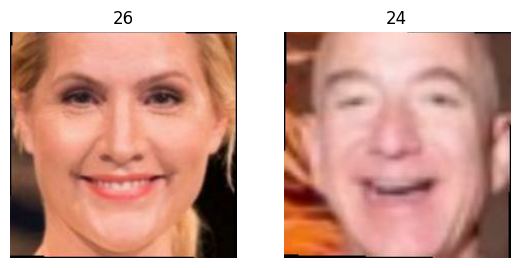

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(2):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [27]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


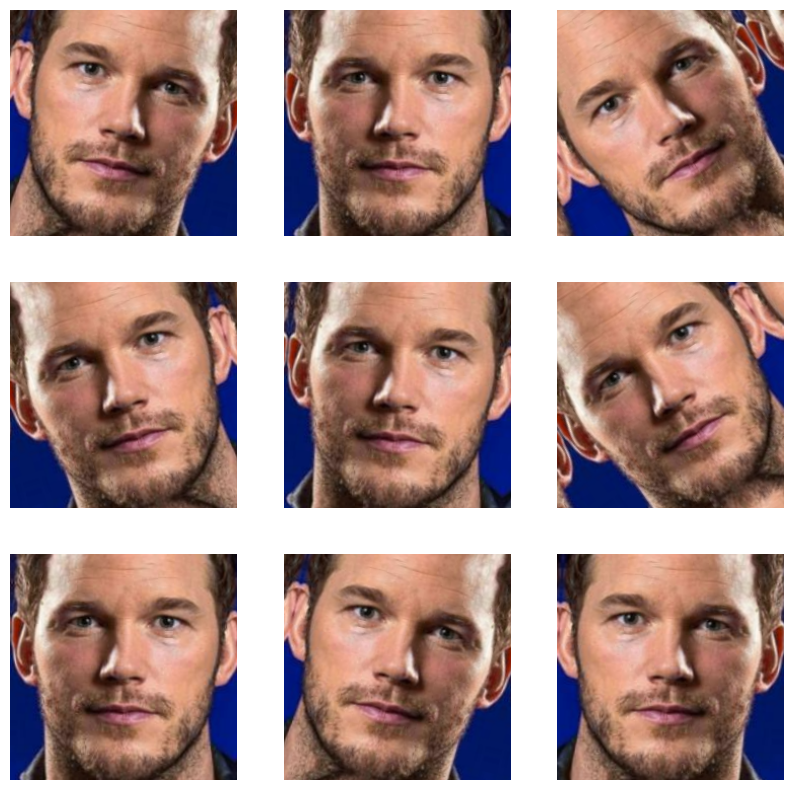

In [28]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
 acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
 augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this is the better option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
 augmented images, like this:

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
 be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
 asynchronous and non-blocking.

In our case, we'll go with the first option.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [29]:
train_ds = train_ds.prefetch(buffer_size=8)
val_ds = val_ds.prefetch(buffer_size=8)


## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


In [12]:
pip install pydot

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


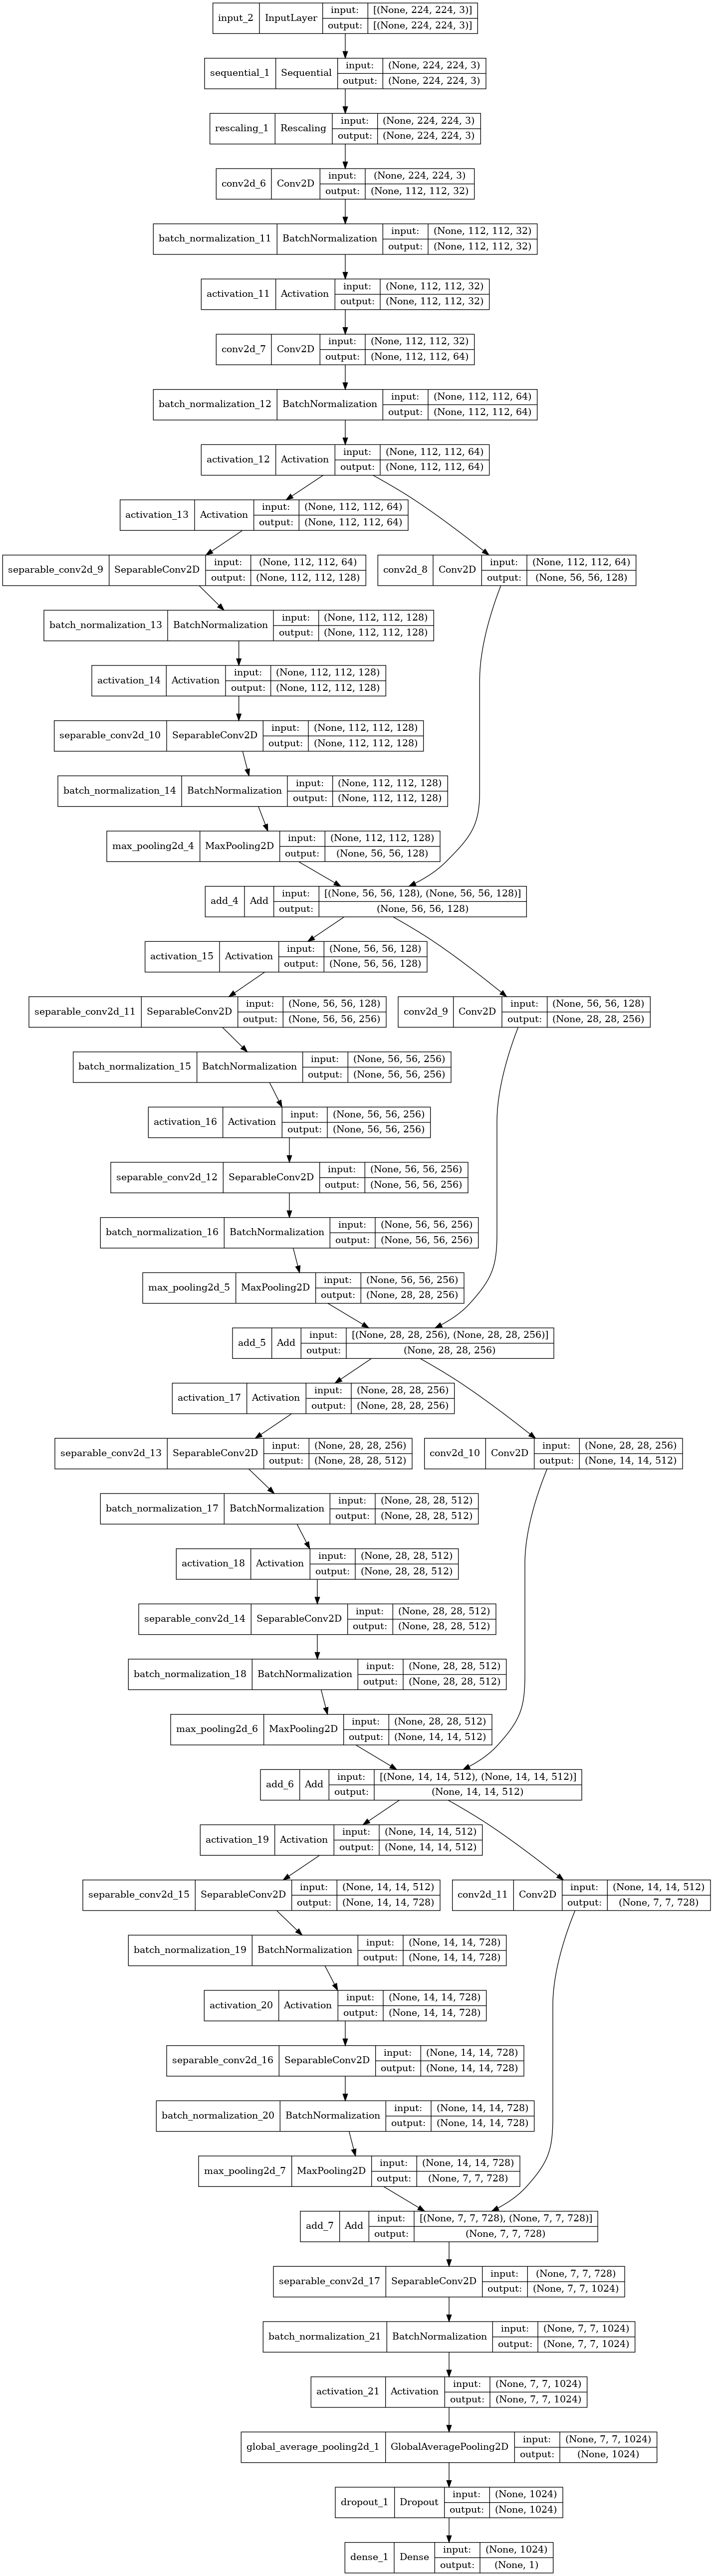

In [30]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


## Train the model


In [31]:
import datetime
log_dir = "logs/fit/classCeleb" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [34]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard
%tensorboard --logdir logs/fit/classCeleb --host 0.0.0.0

In [33]:
epochs = 50

callbacks = [
    #keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds
)


Epoch 1/50
1479/1479 [==============================] - 122s 81ms/step - loss: -47609.1367 - accuracy: 0.0190 - val_loss: -164209.6406 - val_accuracy: 0.0203
Epoch 2/50
  37/1479 [..............................] - ETA: 1:51 - loss: -132146.0312 - accuracy: 0.0203

KeyboardInterrupt: 

We get to ~96% validation accuracy after training for 50 epochs on the full dataset.


## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.


In [23]:
img = keras.preprocessing.image.load_img(
    f"{path}/Masks/613_68b1906b.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent Face and %.2f percent Mask."
    % (100 * (1 - score), 100 * score)
)


This image is 18.66 percent Face and 81.34 percent Mask.
